# experiment 2

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: example_submission.csv  
replace fer2013.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.tar.gz          
replace icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: icml_face_data.csv      y
y

replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train.csv               y
y



In [7]:
!pip install wandb onnx -Uq

# data

In [8]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import wandb

In [9]:
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [10]:
wandb.login()

wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# training

In [11]:
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [0.01, 0.005, 0.001, 0.0005]},
        'batch_size': {'values': [32, 64, 128]},
        'dropout_rate': {'values': [0.2, 0.3, 0.4]},
        'weight_decay': {'values': [1e-4, 1e-5, 1e-6]},
        'hidden_dim': {'values': [64, 128, 256]},
    }
}

In [12]:
sweep_id = wandb.sweep(sweep_config, project="Facial_Expression_Recognition_3")

Create sweep with ID: 8t6mfb6g
Sweep URL: https://wandb.ai/konstantine25b-free-university-of-tbilisi-/Facial_Expression_Recognition_3/sweeps/8t6mfb6g


In [13]:
original_train_df = pd.read_csv('train.csv')

# First split: Create a test set (10% of original data)
train_val_df, test_df = train_test_split(original_train_df, test_size=0.1,
                                         random_state=42, stratify=original_train_df['emotion'])

# Second split: Split remaining data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_val_df, test_size=0.2,
                                    random_state=42, stratify=train_val_df['emotion'])

# Define emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                  4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [14]:
print(f"Original data size: {len(original_train_df)}")
print(f"Training set size: {len(train_df)} ({len(train_df)/len(original_train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(original_train_df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(original_train_df)*100:.1f}%)")

# Print class distribution in each set
print("\nEmotion distribution:")
for i, emotion in emotion_labels.items():
    train_count = sum(train_df['emotion'] == i)
    val_count = sum(val_df['emotion'] == i)
    test_count = sum(test_df['emotion'] == i)
    print(f"  {emotion}: Train={train_count}, Val={val_count}, Test={test_count}")


Original data size: 28709
Training set size: 20670 (72.0%)
Validation set size: 5168 (18.0%)
Test set size: 2871 (10.0%)

Emotion distribution:
  Angry: Train=2877, Val=719, Test=399
  Disgust: Train=314, Val=78, Test=44
  Fear: Train=2950, Val=737, Test=410
  Happy: Train=5194, Val=1299, Test=722
  Sad: Train=3477, Val=870, Test=483
  Surprise: Train=2283, Val=571, Test=317
  Neutral: Train=3575, Val=894, Test=496


In [15]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        pixels = [int(pixel) for pixel in row['pixels'].split()]
        image = np.array(pixels, dtype=np.uint8).reshape(48, 48)

        # Convert to PIL Image for transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = row['emotion']
        return image, label

In [16]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Validation and test sets only need basic transformations
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [17]:
train_dataset = FER2013Dataset(train_df, transform=train_transform)
val_dataset = FER2013Dataset(val_df, transform=val_test_transform)
test_dataset = FER2013Dataset(test_df, transform=val_test_transform)

# Create a small subset for overfitting test (20 samples)
indices = list(range(20))
overfit_dataset = torch.utils.data.Subset(train_dataset, indices)

In [18]:
class ImprovedCNN(nn.Module):
    def __init__(self, dropout_rate=0.3, hidden_dim=128):
        super(ImprovedCNN, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(128 * 6 * 6, hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 7)

    def forward(self, x):

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x


In [19]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    overfit_loader = DataLoader(overfit_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    return train_loader, val_loader, test_loader, overfit_loader


In [20]:
def compute_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels


# test for 20 data overfit

In [21]:
indices = list(range(20))
overfit_dataset = torch.utils.data.Subset(train_dataset, indices)
overfit_loader = DataLoader(overfit_dataset, batch_size=16, shuffle=True, pin_memory=True)


In [22]:
def test_overfitting():
    print("Running overfitting test to check model architecture...")

    # Initialize model for overfitting test
    model = ImprovedCNN(dropout_rate=0.3, hidden_dim=128).to(device)

    # Define loss function and optimizer for overfitting test
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Initialize wandb run for overfitting test
    with wandb.init(project="Facial_Expression_Recognition_3", name="overfitting_test"):
        overfit_losses = []
        overfit_accs = []

        epochs = 30
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in overfit_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            overfit_loss = running_loss / len(overfit_loader)
            overfit_acc = 100 * correct / total
            overfit_losses.append(overfit_loss)
            overfit_accs.append(overfit_acc)

            # Log to wandb
            wandb.log({
                "overfit_epoch": epoch + 1,
                "overfit_loss": overfit_loss,
                "overfit_accuracy": overfit_acc
            })

            print(f"Overfit Epoch {epoch+1}/{epochs}, Loss: {overfit_loss:.4f}, Acc: {overfit_acc:.2f}%")

        # Plot the overfitting test results
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(overfit_losses)
        plt.title('Overfitting Test - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(overfit_accs)
        plt.title('Overfitting Test - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.savefig('overfit_test.png')
        plt.show()

        wandb.log({"overfit_test_plot": wandb.Image('overfit_test.png')})

        # Check if model can overfit
        if max(overfit_accs) > 95:
            print("Model passed the overfitting test! Proceeding with full training.")
            return True
        else:
            print("Warning: Model may have issues with gradient flow as it didn't achieve high accuracy on the small dataset.")
            return False


Running overfitting test to check model architecture...


Overfit Epoch 1/30, Loss: 2.2239, Acc: 15.00%
Overfit Epoch 2/30, Loss: 1.6628, Acc: 45.00%
Overfit Epoch 3/30, Loss: 1.3951, Acc: 70.00%
Overfit Epoch 4/30, Loss: 1.7149, Acc: 70.00%
Overfit Epoch 5/30, Loss: 0.9505, Acc: 85.00%
Overfit Epoch 6/30, Loss: 1.0558, Acc: 85.00%
Overfit Epoch 7/30, Loss: 0.8385, Acc: 90.00%
Overfit Epoch 8/30, Loss: 1.1384, Acc: 75.00%
Overfit Epoch 9/30, Loss: 0.7479, Acc: 95.00%
Overfit Epoch 10/30, Loss: 0.7996, Acc: 90.00%
Overfit Epoch 11/30, Loss: 0.7236, Acc: 95.00%
Overfit Epoch 12/30, Loss: 0.8822, Acc: 95.00%
Overfit Epoch 13/30, Loss: 0.6823, Acc: 100.00%
Overfit Epoch 14/30, Loss: 0.6679, Acc: 95.00%
Overfit Epoch 15/30, Loss: 0.9049, Acc: 85.00%
Overfit Epoch 16/30, Loss: 0.6221, Acc: 95.00%
Overfit Epoch 17/30, Loss: 0.5031, Acc: 100.00%
Overfit Epoch 18/30, Loss: 0.5932, Acc: 95.00%
Overfit Epoch 19/30, Loss: 0.7254, Acc: 95.00%
Overfit Epoch 20/30, Loss: 0.3885, Acc: 95.00%
Overfit Epoch 21/30, Loss: 0.5984, Acc: 100.00%
Overfit Epoch 22/30

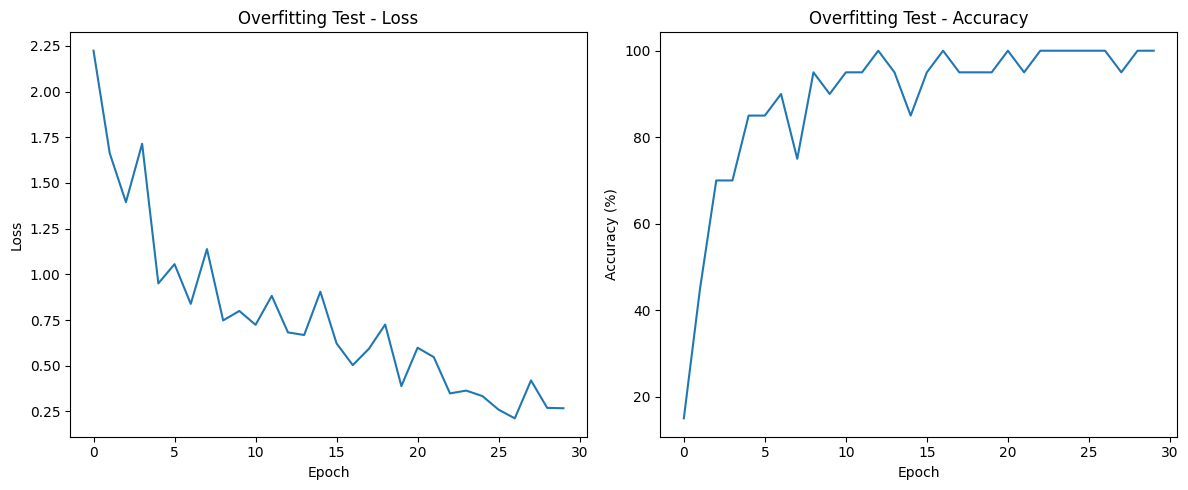

Model passed the overfitting test! Proceeding with full training.


In [23]:
passed_overfit_test = test_overfitting()

# Training model

In [24]:
def compute_loss(loader, model, criterion, device):
    """Compute the loss on a dataset without updating model parameters"""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

def visualize_predictions(loader, model, emotion_labels, device, num_samples=8):
    """Visualize model predictions on a few samples"""
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Convert to CPU for visualization
            all_images.extend(images.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())

            if len(all_images) >= num_samples:
                break

    # Select a subset of images to display
    indices = np.random.choice(len(all_images), min(num_samples, len(all_images)), replace=False)

    # Create a grid of images with their true and predicted labels
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i < len(axes):
            img = all_images[idx].squeeze()  # Remove channel dimension for grayscale
            img = (img * 0.5) + 0.5  # Denormalize

            true_label = emotion_labels[all_labels[idx]]
            pred_label = emotion_labels[all_preds[idx]]

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    wandb.log({"prediction_samples": wandb.Image('prediction_samples.png')})


In [28]:
def train_model(config=None):
    with wandb.init(project="Facial_Expression_Recognition_3", config=config):
        # Access all hyperparameter values from wandb.config
        config = wandb.config

        # Create model and dataloaders with the current config
        model = ImprovedCNN(dropout_rate=config.dropout_rate, hidden_dim=config.hidden_dim).to(device)
        train_loader, val_loader, test_loader, _ = create_dataloaders(config.batch_size)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True)

        # Initialize best validation accuracy
        best_val_acc = 0
        best_model_path = f"best_model_{wandb.run.id}.pt"

        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_acc = 100 * train_correct / train_total

            # Validation phase
            val_acc, val_preds, val_labels = compute_accuracy(val_loader, model, device)
            val_loss = compute_loss(val_loader, model, criterion, device)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

            # Print progress
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Update learning rate scheduler
            scheduler.step(val_acc)

            # Save the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
                print(f"Model improved! Saved checkpoint (Val Acc: {val_acc:.2f}%)")

                # Log confusion matrix for best model
                cm = confusion_matrix(val_labels, val_preds)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=list(emotion_labels.values()),
                            yticklabels=list(emotion_labels.values()))
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title(f'Confusion Matrix (Validation) - Epoch {epoch+1}')
                plt.tight_layout()
                plt.savefig(f'confusion_matrix_epoch_{epoch+1}.png')
                wandb.log({"confusion_matrix": wandb.Image(f'confusion_matrix_epoch_{epoch+1}.png')})

        # Load the best model for final evaluation
        model.load_state_dict(torch.load(best_model_path))

        # Test the model
        test_accuracy, test_preds, test_labels = compute_accuracy(test_loader, model, device)

        # Compute per-class metrics
        report = classification_report(test_labels, test_preds,
                                       target_names=list(emotion_labels.values()),
                                       output_dict=True)

        # Log test results
        wandb.log({
            "test_accuracy": test_accuracy,
            "test_f1_macro": report['macro avg']['f1-score'],
            "test_precision_macro": report['macro avg']['precision'],
            "test_recall_macro": report['macro avg']['recall']
        })

        # Log per-class metrics
        for emotion_idx, emotion_name in emotion_labels.items():
            if emotion_name in report:
                wandb.log({
                    f"test_{emotion_name}_f1": report[emotion_name]['f1-score'],
                    f"test_{emotion_name}_precision": report[emotion_name]['precision'],
                    f"test_{emotion_name}_recall": report[emotion_name]['recall']
                })

        # Create and log confusion matrix for test set
        cm = confusion_matrix(test_labels, test_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(emotion_labels.values()),
                    yticklabels=list(emotion_labels.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Test)')
        plt.tight_layout()
        plt.savefig('test_confusion_matrix.png')
        wandb.log({"test_confusion_matrix": wandb.Image('test_confusion_matrix.png')})

        # Visualize some predictions
        visualize_predictions(test_loader, model, emotion_labels, device)

        print(f"Final Test Accuracy: {test_accuracy:.2f}%")
        return model, test_accuracy


In [29]:
print("Running full model training...")
default_config = {
    'learning_rate': 0.001,
    'batch_size': 64,
    'dropout_rate': 0.3,
    'weight_decay': 1e-5,
    'hidden_dim': 128
}

Running full model training...


Epoch 1/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.5304, Train Acc: 40.42%, Val Loss: 1.3504, Val Acc: 49.25%
Model improved! Saved checkpoint (Val Acc: 49.25%)


Epoch 2/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 1.3116, Train Acc: 49.97%, Val Loss: 1.2417, Val Acc: 52.75%
Model improved! Saved checkpoint (Val Acc: 52.75%)


Epoch 3/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 1.2338, Train Acc: 52.99%, Val Loss: 1.1900, Val Acc: 54.80%
Model improved! Saved checkpoint (Val Acc: 54.80%)


Epoch 4/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 1.1810, Train Acc: 55.34%, Val Loss: 1.1653, Val Acc: 56.33%
Model improved! Saved checkpoint (Val Acc: 56.33%)


Epoch 5/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 1.1440, Train Acc: 56.78%, Val Loss: 1.1489, Val Acc: 57.08%
Model improved! Saved checkpoint (Val Acc: 57.08%)


Epoch 6/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 1.1072, Train Acc: 58.08%, Val Loss: 1.1543, Val Acc: 56.73%


Epoch 7/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 1.0703, Train Acc: 59.41%, Val Loss: 1.1169, Val Acc: 59.08%
Model improved! Saved checkpoint (Val Acc: 59.08%)


Epoch 8/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 1.0444, Train Acc: 60.52%, Val Loss: 1.1105, Val Acc: 59.29%
Model improved! Saved checkpoint (Val Acc: 59.29%)


Epoch 9/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 1.0200, Train Acc: 61.92%, Val Loss: 1.1382, Val Acc: 58.42%


Epoch 10/20 [Train]:   0%|          | 0/323 [00:10<?, ?it/s]

Epoch 10/20, Train Loss: 0.9955, Train Acc: 62.45%, Val Loss: 1.1140, Val Acc: 59.56%
Model improved! Saved checkpoint (Val Acc: 59.56%)


Epoch 11/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.9722, Train Acc: 63.12%, Val Loss: 1.1144, Val Acc: 58.11%


Epoch 12/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.9495, Train Acc: 64.18%, Val Loss: 1.1128, Val Acc: 59.19%


Epoch 13/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.9345, Train Acc: 64.97%, Val Loss: 1.0945, Val Acc: 60.26%
Model improved! Saved checkpoint (Val Acc: 60.26%)


Epoch 14/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.9024, Train Acc: 66.17%, Val Loss: 1.1040, Val Acc: 60.33%
Model improved! Saved checkpoint (Val Acc: 60.33%)


Epoch 15/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.8841, Train Acc: 66.75%, Val Loss: 1.1197, Val Acc: 59.02%


Epoch 16/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.8741, Train Acc: 66.99%, Val Loss: 1.1026, Val Acc: 60.20%


Epoch 17/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.8475, Train Acc: 68.23%, Val Loss: 1.1023, Val Acc: 60.68%
Model improved! Saved checkpoint (Val Acc: 60.68%)


Epoch 18/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.8320, Train Acc: 68.55%, Val Loss: 1.1215, Val Acc: 60.35%


Epoch 19/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.8095, Train Acc: 69.77%, Val Loss: 1.1437, Val Acc: 59.58%


Epoch 20/20 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.7942, Train Acc: 70.46%, Val Loss: 1.1547, Val Acc: 60.10%
Final Test Accuracy: 60.88%


Training completed with test accuracy: 60.88%


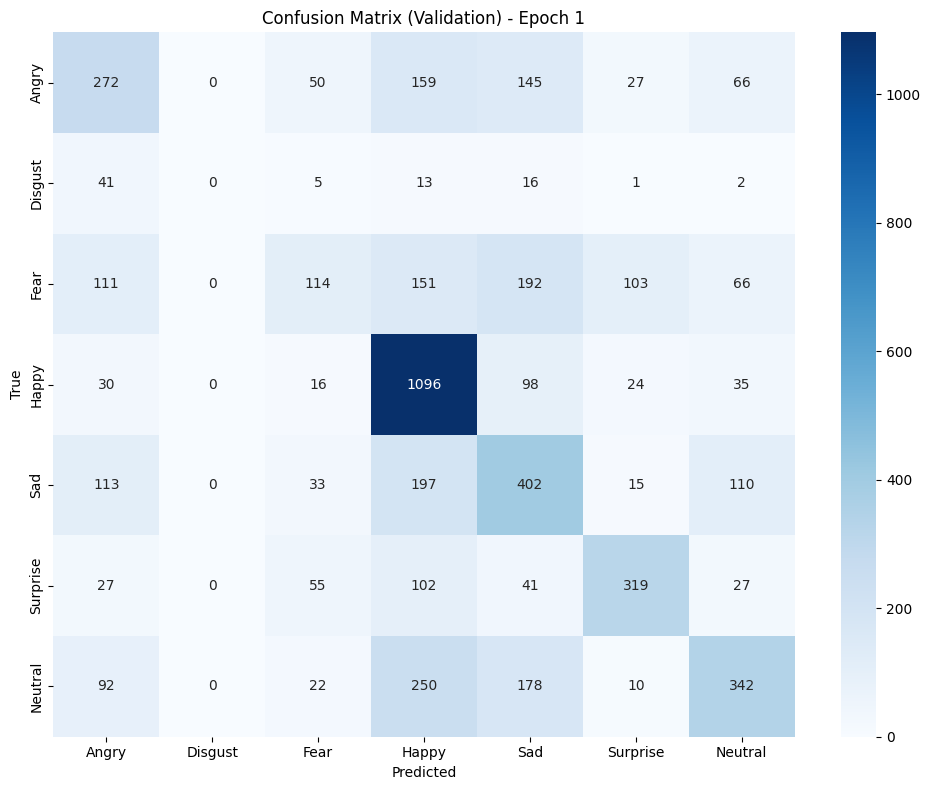

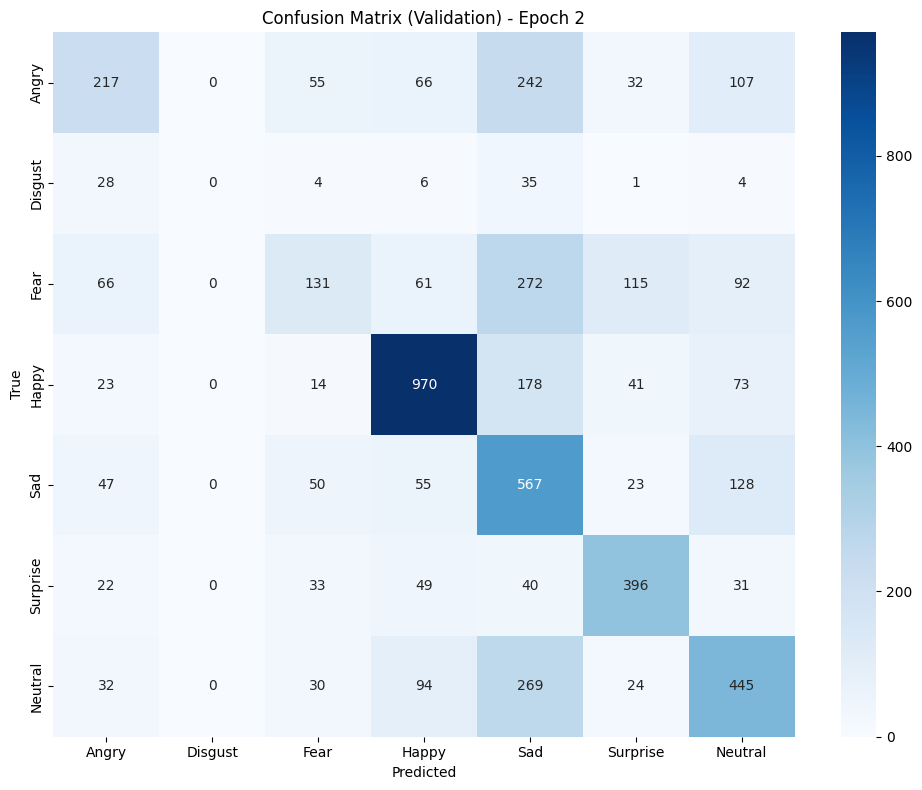

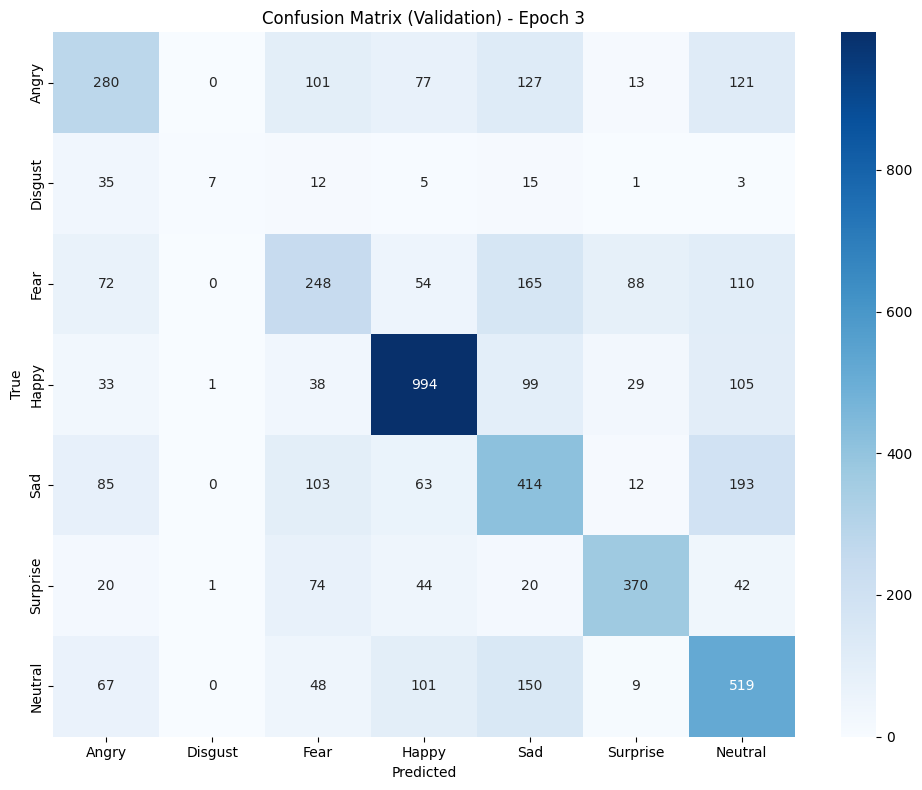

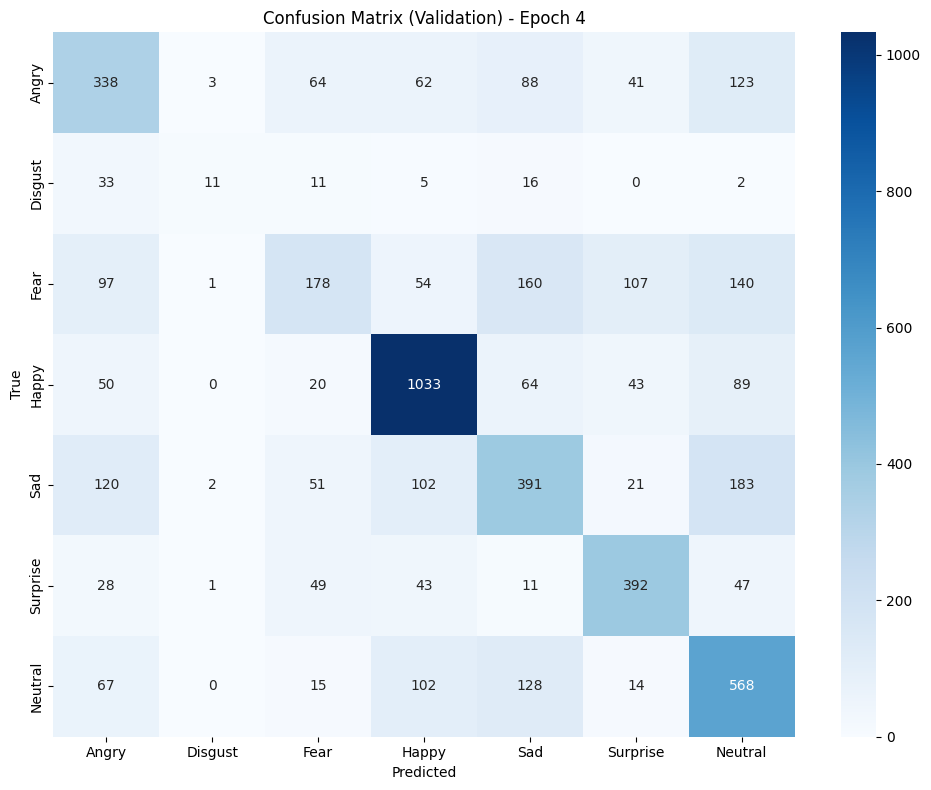

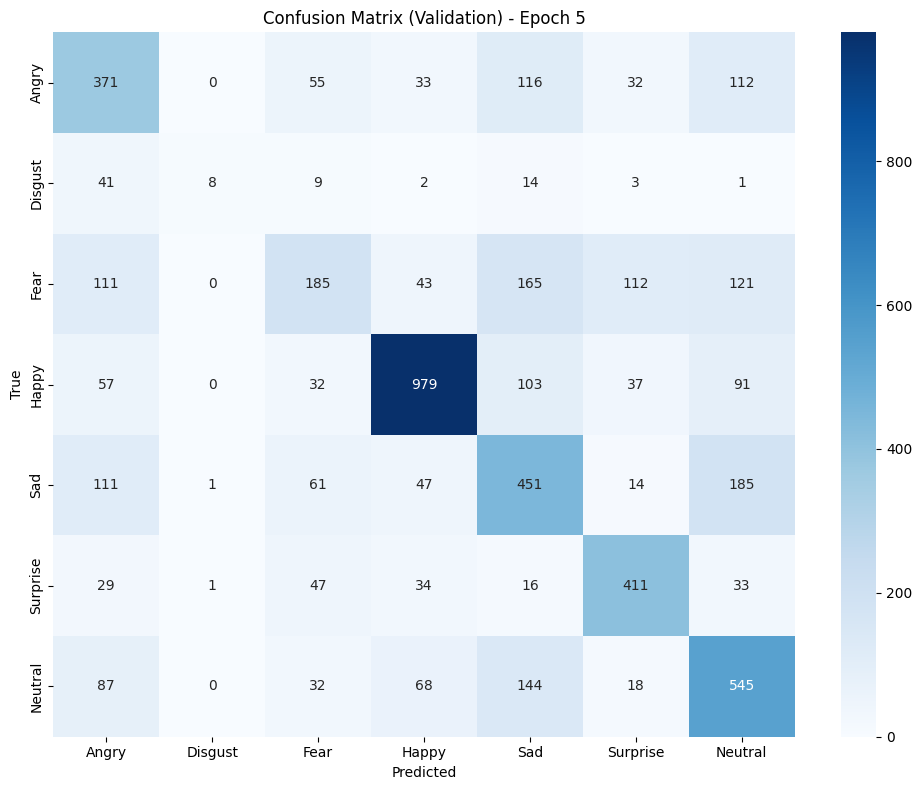

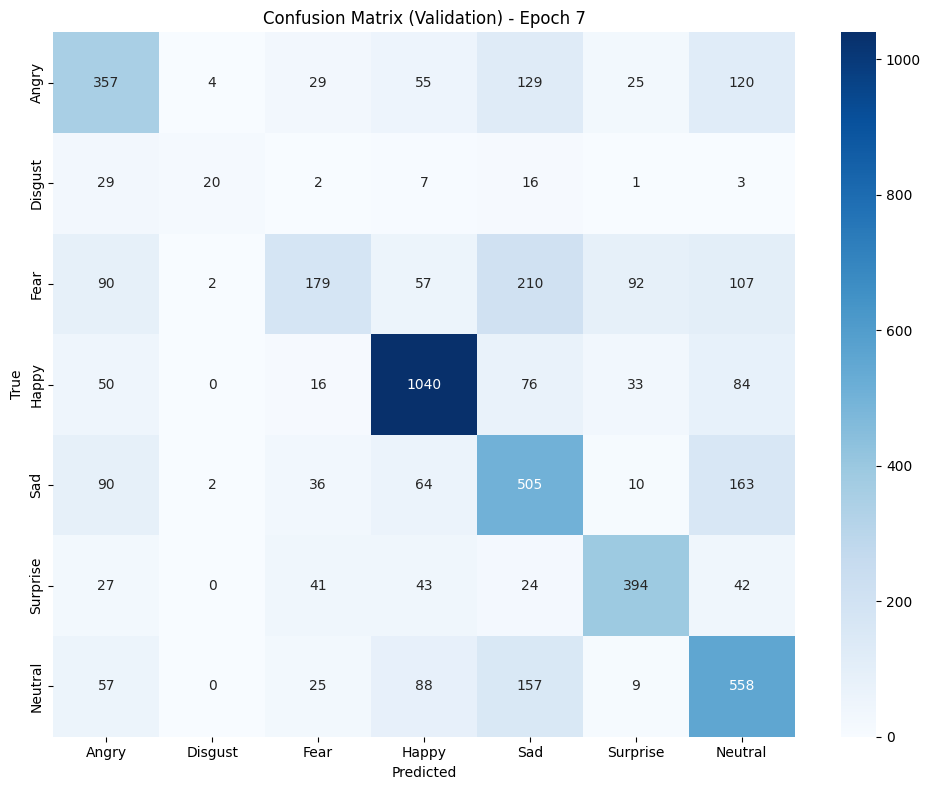

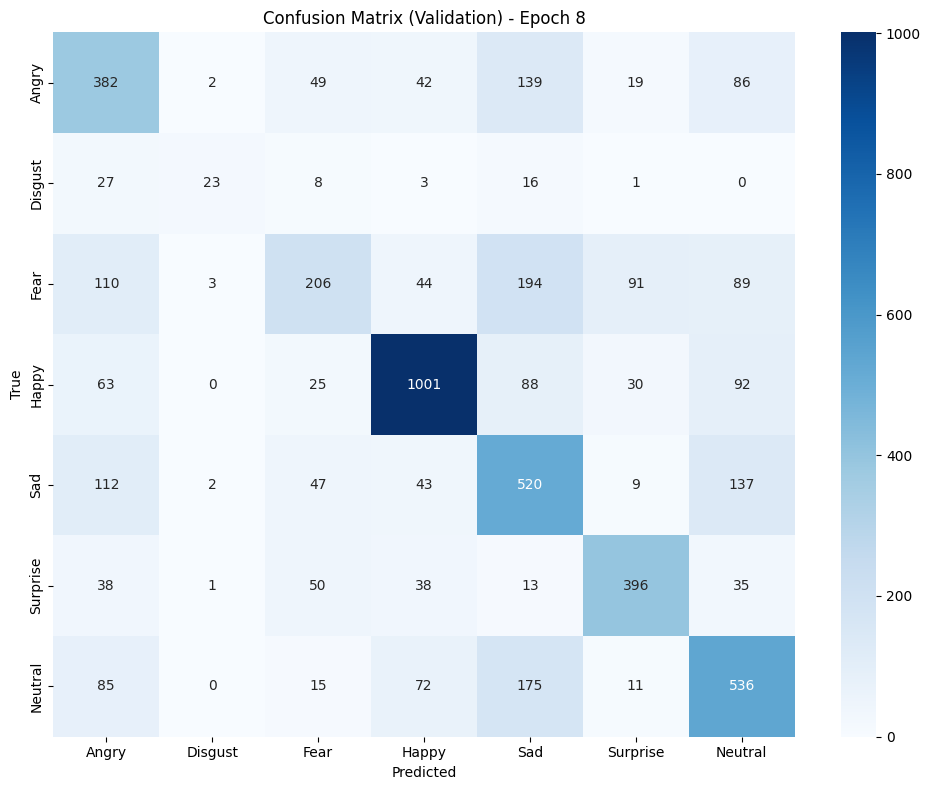

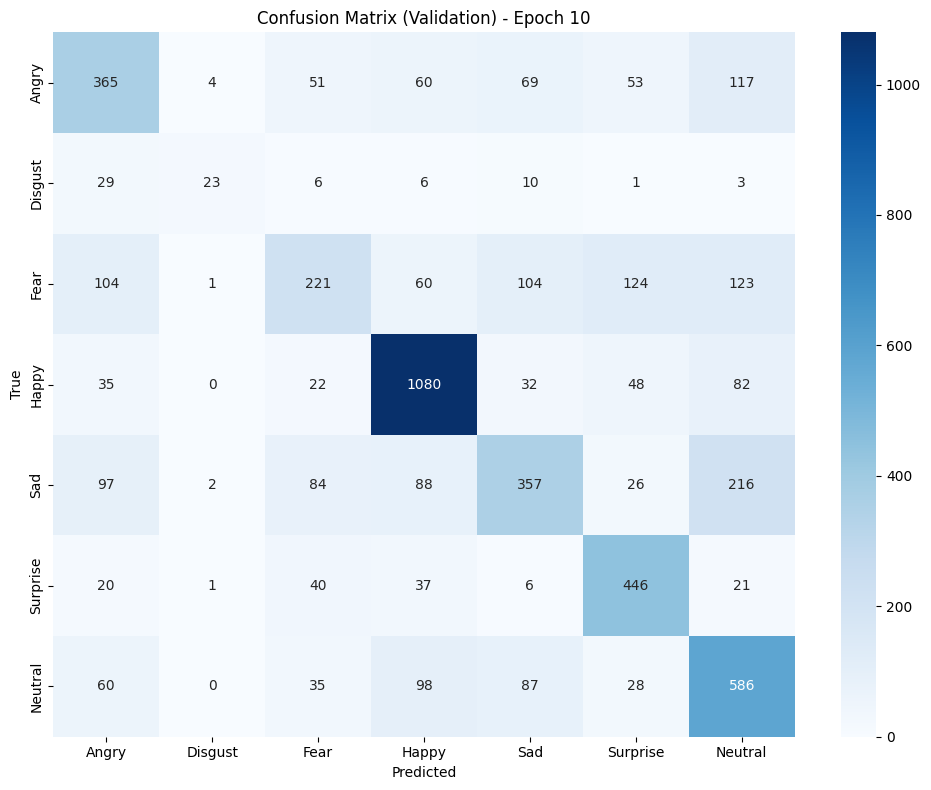

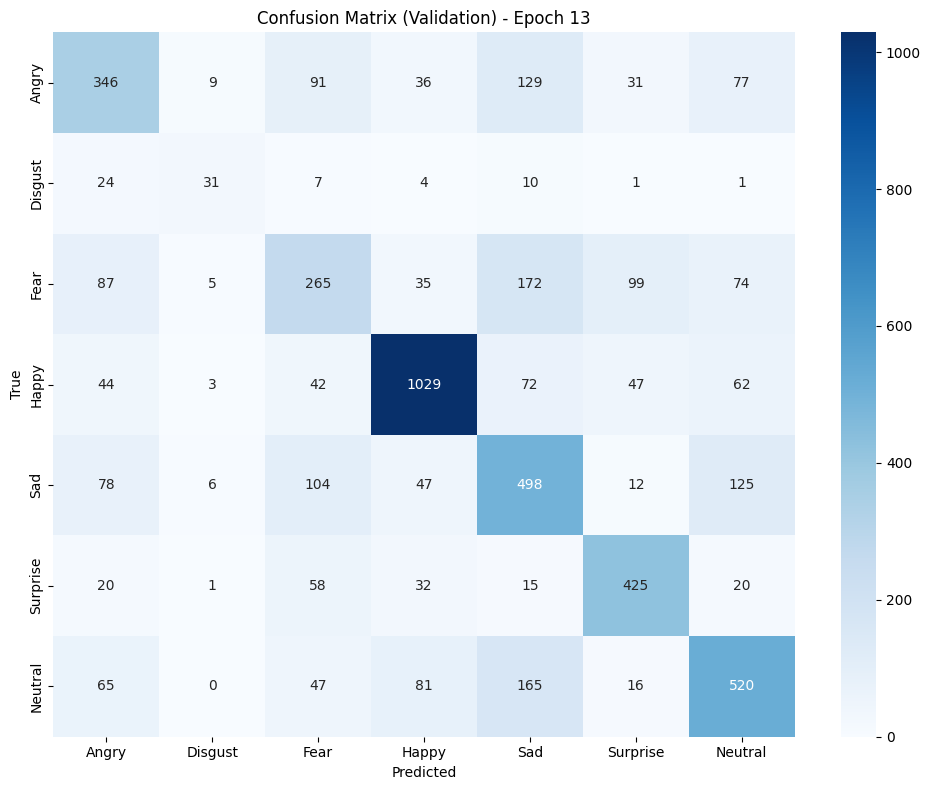

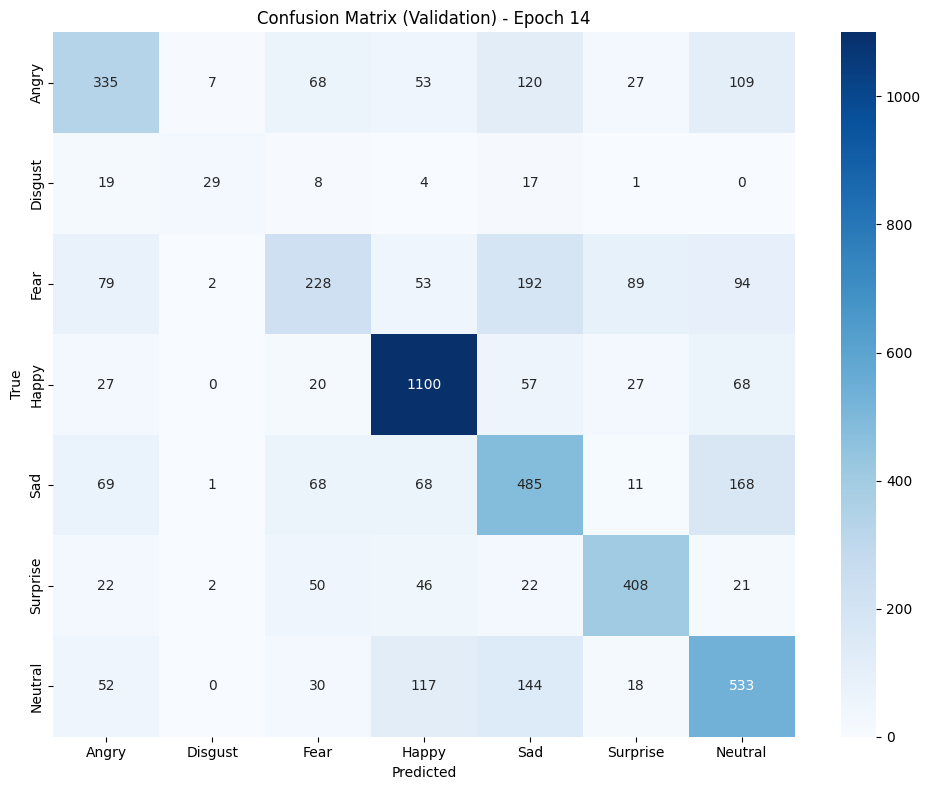

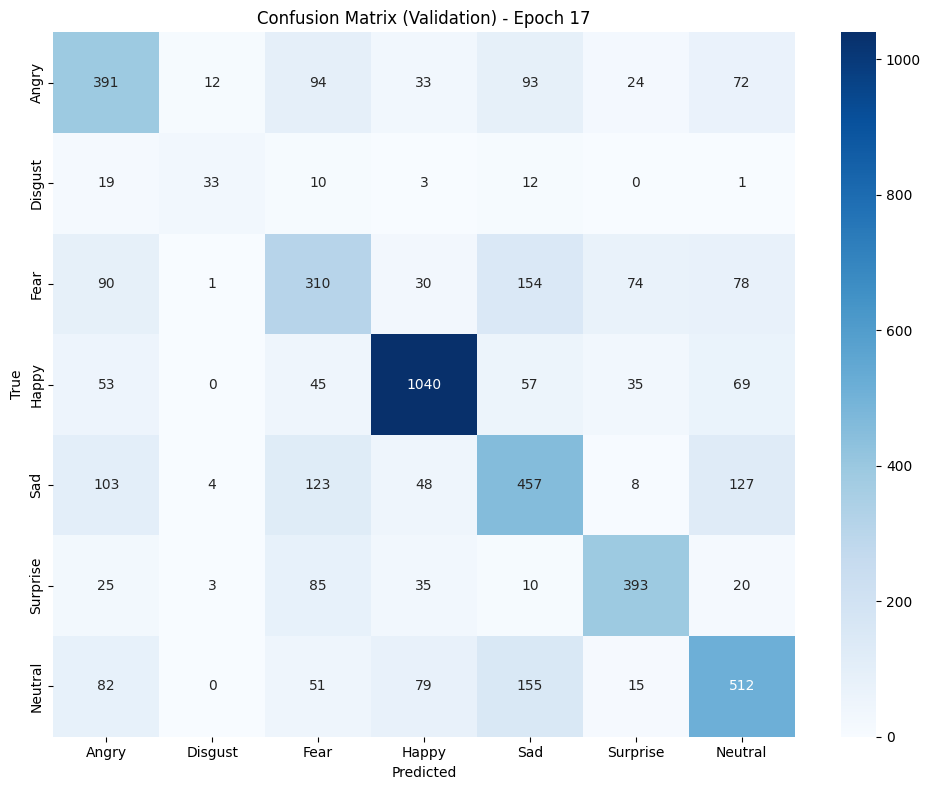

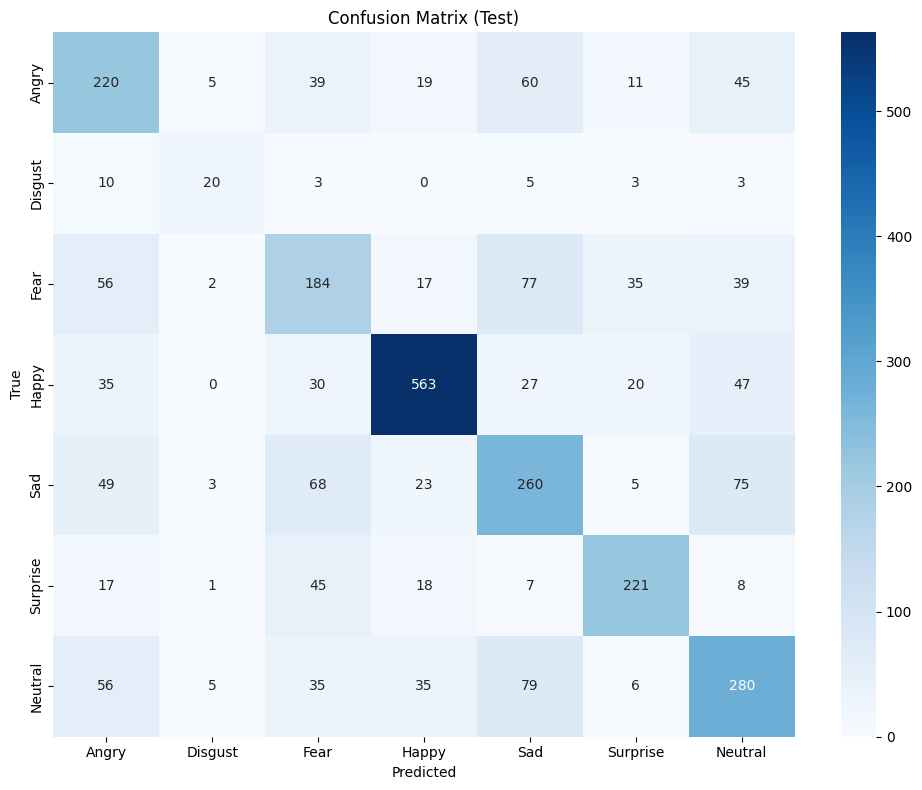

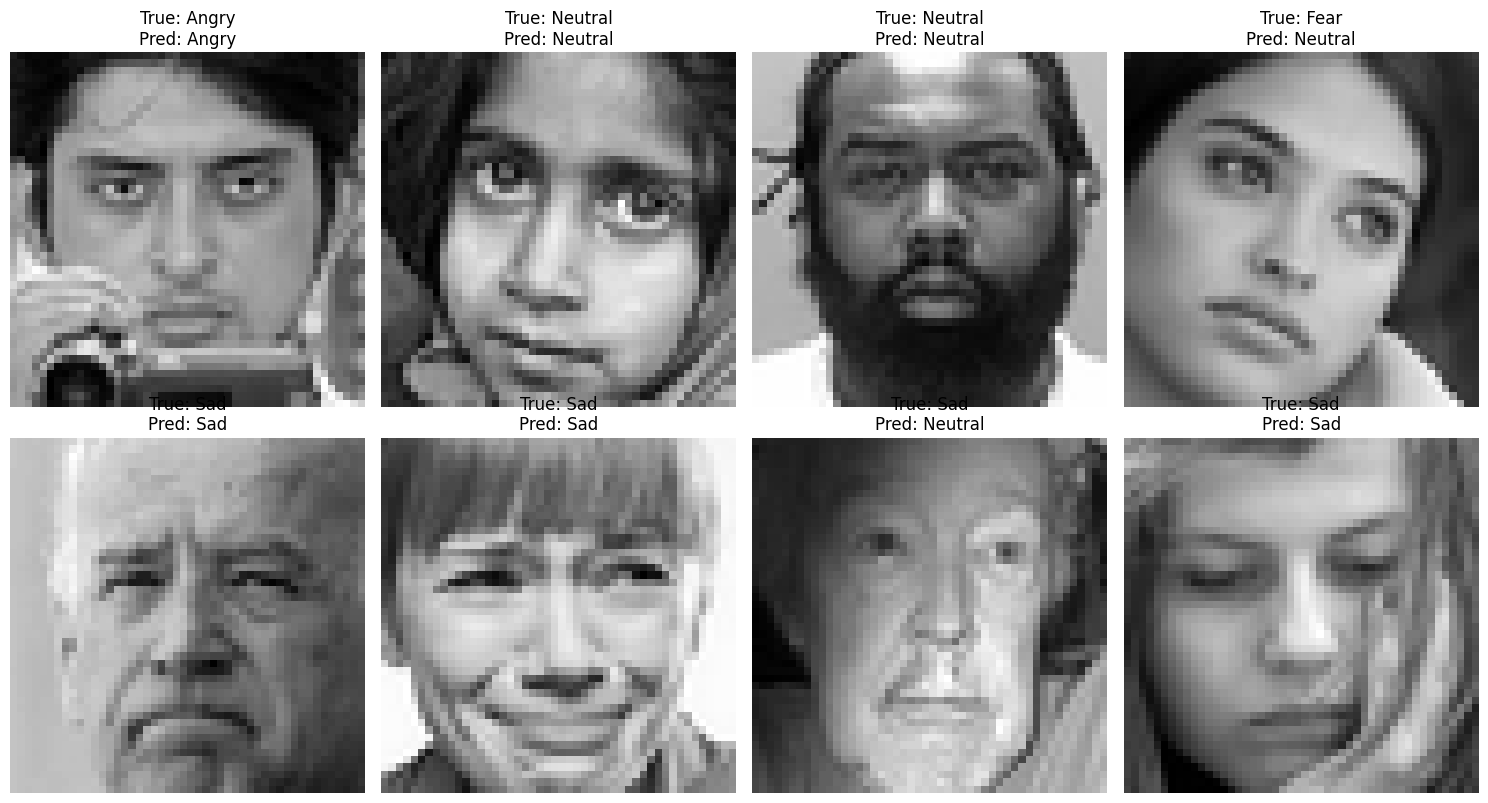

In [30]:
model, test_accuracy = train_model(default_config)
print(f"Training completed with test accuracy: {test_accuracy:.2f}%")



Running hyperparameter sweep to find the best model...


wandb: Agent Starting Run: f6esazbt with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	weight_decay: 1e-06


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.5679, Train Acc: 39.45%, Val Loss: 1.3749, Val Acc: 46.90%
Model improved! Saved checkpoint (Val Acc: 46.90%)


Epoch 2/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 1.3367, Train Acc: 48.98%, Val Loss: 1.2762, Val Acc: 51.20%
Model improved! Saved checkpoint (Val Acc: 51.20%)


Epoch 3/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 1.2595, Train Acc: 52.29%, Val Loss: 1.2227, Val Acc: 53.64%
Model improved! Saved checkpoint (Val Acc: 53.64%)


Epoch 4/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 1.2032, Train Acc: 54.29%, Val Loss: 1.1876, Val Acc: 55.11%
Model improved! Saved checkpoint (Val Acc: 55.11%)


Epoch 5/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 1.1565, Train Acc: 56.43%, Val Loss: 1.1622, Val Acc: 56.73%
Model improved! Saved checkpoint (Val Acc: 56.73%)


Epoch 6/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 1.1215, Train Acc: 57.56%, Val Loss: 1.2279, Val Acc: 52.59%


Epoch 7/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 1.0950, Train Acc: 58.53%, Val Loss: 1.1407, Val Acc: 57.28%
Model improved! Saved checkpoint (Val Acc: 57.28%)


Epoch 8/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 1.0609, Train Acc: 59.55%, Val Loss: 1.1440, Val Acc: 57.06%


Epoch 9/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 1.0417, Train Acc: 60.81%, Val Loss: 1.1456, Val Acc: 56.97%


Epoch 10/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1105059800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1105059800>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
      ^ ^ ^ ^ ^ ^ ^^^ ^ ^^^^
^  File "/

Epoch 10/20, Train Loss: 1.0158, Train Acc: 61.78%, Val Loss: 1.1195, Val Acc: 58.59%
Model improved! Saved checkpoint (Val Acc: 58.59%)


Epoch 11/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.9967, Train Acc: 62.27%, Val Loss: 1.1230, Val Acc: 58.11%


Epoch 12/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.9737, Train Acc: 63.16%, Val Loss: 1.1110, Val Acc: 59.42%
Model improved! Saved checkpoint (Val Acc: 59.42%)


Epoch 13/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.9590, Train Acc: 63.74%, Val Loss: 1.1239, Val Acc: 59.21%


Epoch 14/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.9349, Train Acc: 64.80%, Val Loss: 1.1094, Val Acc: 59.73%
Model improved! Saved checkpoint (Val Acc: 59.73%)


Epoch 15/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.9207, Train Acc: 65.58%, Val Loss: 1.1055, Val Acc: 59.56%


Epoch 16/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.8973, Train Acc: 66.31%, Val Loss: 1.1610, Val Acc: 58.48%


Epoch 17/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.8837, Train Acc: 66.92%, Val Loss: 1.1126, Val Acc: 60.16%
Model improved! Saved checkpoint (Val Acc: 60.16%)


Epoch 18/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.8629, Train Acc: 67.25%, Val Loss: 1.1197, Val Acc: 60.20%
Model improved! Saved checkpoint (Val Acc: 60.20%)


Epoch 19/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.8508, Train Acc: 67.94%, Val Loss: 1.1244, Val Acc: 60.12%


Epoch 20/20 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.8234, Train Acc: 69.19%, Val Loss: 1.1234, Val Acc: 60.45%
Model improved! Saved checkpoint (Val Acc: 60.45%)
Final Test Accuracy: 60.61%


wandb: Agent Starting Run: 2j17lfpw with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.01
wandb: 	weight_decay: 1e-06


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.5977, Train Acc: 37.45%, Val Loss: 1.3957, Val Acc: 46.01%
Model improved! Saved checkpoint (Val Acc: 46.01%)


Epoch 2/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 1.3838, Train Acc: 46.96%, Val Loss: 1.2903, Val Acc: 50.74%
Model improved! Saved checkpoint (Val Acc: 50.74%)


Epoch 3/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 1.3118, Train Acc: 49.42%, Val Loss: 1.2175, Val Acc: 53.85%
Model improved! Saved checkpoint (Val Acc: 53.85%)


Epoch 4/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 1.2585, Train Acc: 52.06%, Val Loss: 1.2818, Val Acc: 51.34%


Epoch 5/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 1.2209, Train Acc: 53.53%, Val Loss: 1.1996, Val Acc: 54.61%
Model improved! Saved checkpoint (Val Acc: 54.61%)


Epoch 6/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 1.1908, Train Acc: 54.57%, Val Loss: 1.2190, Val Acc: 54.91%
Model improved! Saved checkpoint (Val Acc: 54.91%)


Epoch 7/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 1.1711, Train Acc: 55.76%, Val Loss: 1.1414, Val Acc: 57.43%
Model improved! Saved checkpoint (Val Acc: 57.43%)


Epoch 8/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 1.1447, Train Acc: 56.49%, Val Loss: 1.1402, Val Acc: 57.66%
Model improved! Saved checkpoint (Val Acc: 57.66%)


<ipython-input-28-21af470f896e>:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


Epoch 9/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 1.1174, Train Acc: 57.61%, Val Loss: 1.1439, Val Acc: 56.58%


Epoch 10/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 1.1009, Train Acc: 58.21%, Val Loss: 1.1868, Val Acc: 54.97%


Epoch 11/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 1.0869, Train Acc: 58.55%, Val Loss: 1.1141, Val Acc: 58.84%
Model improved! Saved checkpoint (Val Acc: 58.84%)


Epoch 12/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 1.0730, Train Acc: 59.08%, Val Loss: 1.1308, Val Acc: 57.68%


Epoch 13/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 1.0490, Train Acc: 60.10%, Val Loss: 1.1399, Val Acc: 58.57%


Epoch 14/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 1.0335, Train Acc: 61.09%, Val Loss: 1.1476, Val Acc: 57.53%


Epoch 15/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 1.0196, Train Acc: 61.58%, Val Loss: 1.1147, Val Acc: 59.60%
Model improved! Saved checkpoint (Val Acc: 59.60%)


Epoch 16/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 1.0025, Train Acc: 62.24%, Val Loss: 1.1183, Val Acc: 58.40%


Epoch 17/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.9979, Train Acc: 62.24%, Val Loss: 1.1321, Val Acc: 58.73%


Epoch 18/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.9889, Train Acc: 62.61%, Val Loss: 1.1044, Val Acc: 59.33%


Epoch 19/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.9655, Train Acc: 63.59%, Val Loss: 1.1155, Val Acc: 60.06%
Model improved! Saved checkpoint (Val Acc: 60.06%)


Epoch 20/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.9518, Train Acc: 63.59%, Val Loss: 1.1270, Val Acc: 59.42%
Final Test Accuracy: 60.61%


wandb: Agent Starting Run: 7i3xnqi1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.005
wandb: 	weight_decay: 0.0001


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.5653, Train Acc: 38.52%, Val Loss: 1.3954, Val Acc: 46.83%
Model improved! Saved checkpoint (Val Acc: 46.83%)


Epoch 2/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 1.3492, Train Acc: 48.31%, Val Loss: 1.3428, Val Acc: 49.55%
Model improved! Saved checkpoint (Val Acc: 49.55%)


Epoch 3/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 1.2921, Train Acc: 50.57%, Val Loss: 1.2629, Val Acc: 53.19%
Model improved! Saved checkpoint (Val Acc: 53.19%)


Epoch 4/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 1.2591, Train Acc: 52.68%, Val Loss: 1.2207, Val Acc: 54.32%
Model improved! Saved checkpoint (Val Acc: 54.32%)


Epoch 5/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 1.2340, Train Acc: 52.75%, Val Loss: 1.2152, Val Acc: 54.32%


Epoch 6/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 1.2153, Train Acc: 53.66%, Val Loss: 1.2222, Val Acc: 54.32%


Epoch 7/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 1.2010, Train Acc: 54.02%, Val Loss: 1.2445, Val Acc: 53.27%


Epoch 8/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 1.1915, Train Acc: 54.86%, Val Loss: 1.1800, Val Acc: 55.77%
Model improved! Saved checkpoint (Val Acc: 55.77%)


Epoch 9/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 1.1665, Train Acc: 55.67%, Val Loss: 1.1632, Val Acc: 56.11%
Model improved! Saved checkpoint (Val Acc: 56.11%)


Epoch 10/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 1.1638, Train Acc: 55.97%, Val Loss: 1.1913, Val Acc: 56.35%
Model improved! Saved checkpoint (Val Acc: 56.35%)


Epoch 11/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 1.1508, Train Acc: 56.12%, Val Loss: 1.1576, Val Acc: 55.79%


Epoch 12/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 1.1422, Train Acc: 56.87%, Val Loss: 1.1465, Val Acc: 57.49%
Model improved! Saved checkpoint (Val Acc: 57.49%)


Epoch 13/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 1.1419, Train Acc: 56.68%, Val Loss: 1.1601, Val Acc: 56.19%


Epoch 14/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 1.1267, Train Acc: 57.47%, Val Loss: 1.1553, Val Acc: 57.06%


Epoch 15/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 1.1178, Train Acc: 57.32%, Val Loss: 1.1727, Val Acc: 56.52%


Epoch 16/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 1.1250, Train Acc: 57.25%, Val Loss: 1.1603, Val Acc: 56.54%


Epoch 17/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 1.0499, Train Acc: 60.21%, Val Loss: 1.0808, Val Acc: 60.29%
Model improved! Saved checkpoint (Val Acc: 60.29%)


Epoch 18/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 1.0205, Train Acc: 61.46%, Val Loss: 1.0957, Val Acc: 59.67%


Epoch 19/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 1.0042, Train Acc: 61.90%, Val Loss: 1.0868, Val Acc: 59.89%


Epoch 20/20 [Train]:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.9929, Train Acc: 62.31%, Val Loss: 1.0840, Val Acc: 59.42%
Final Test Accuracy: 60.99%


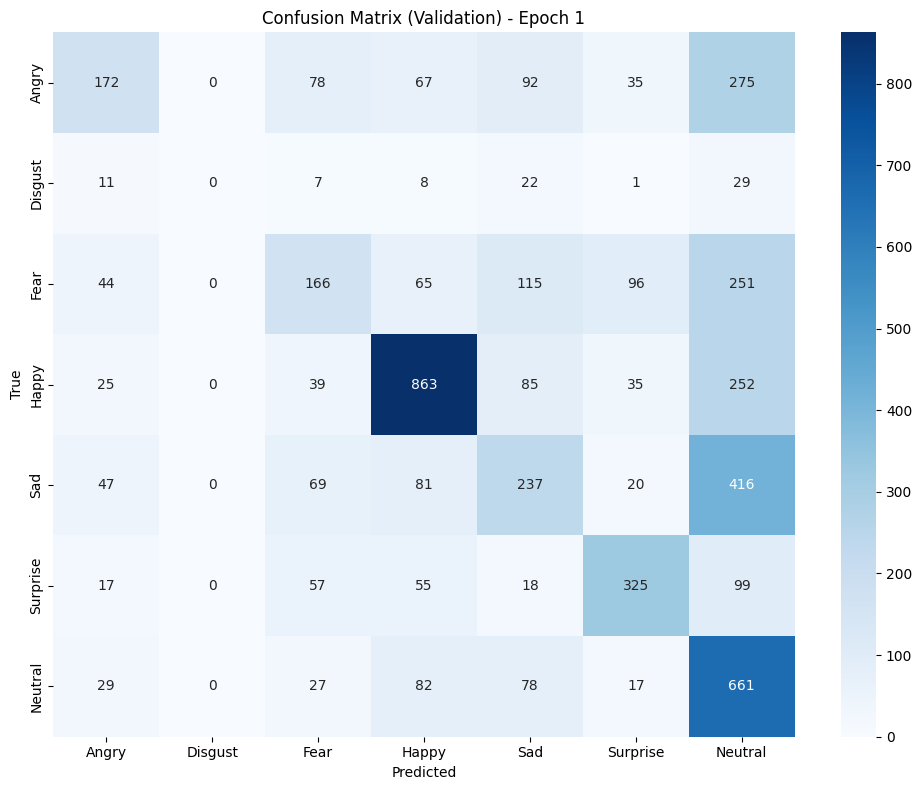

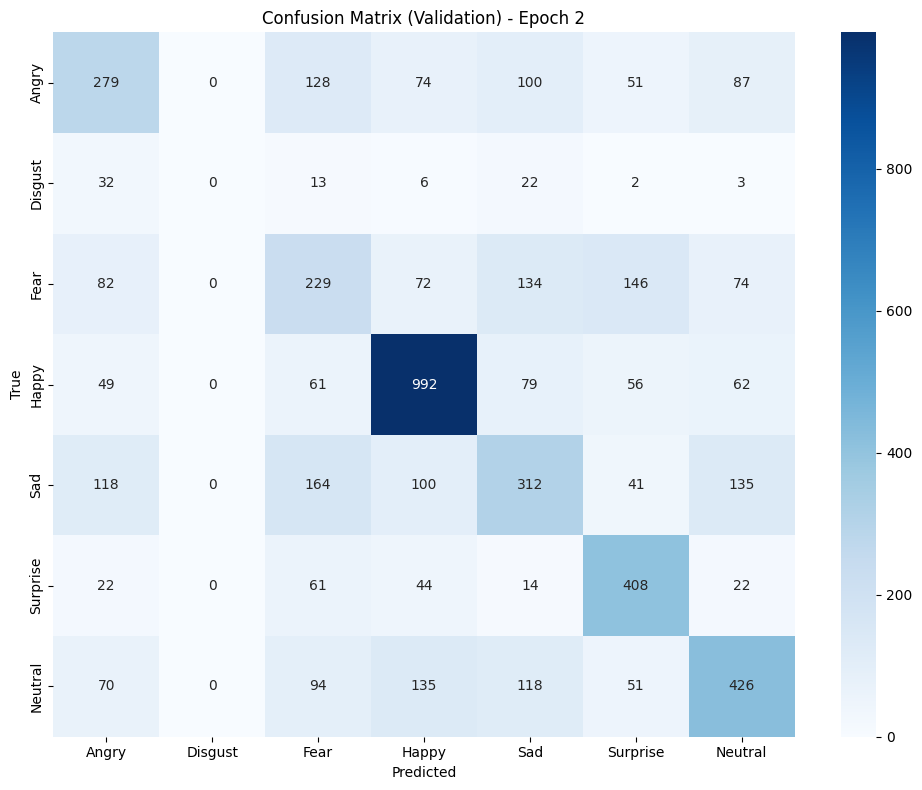

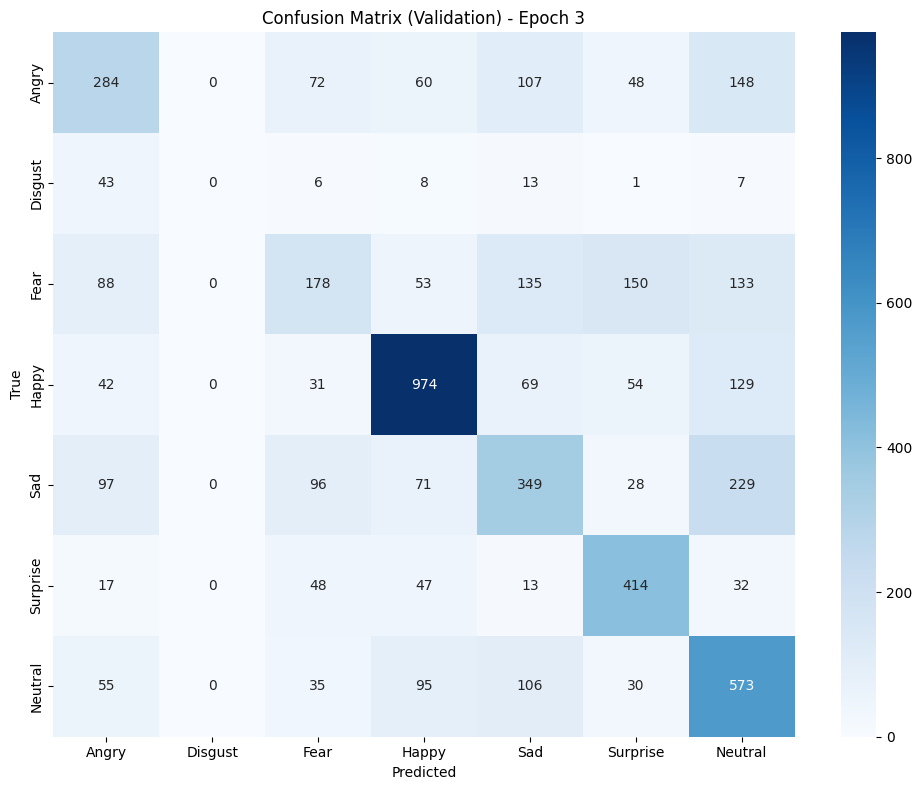

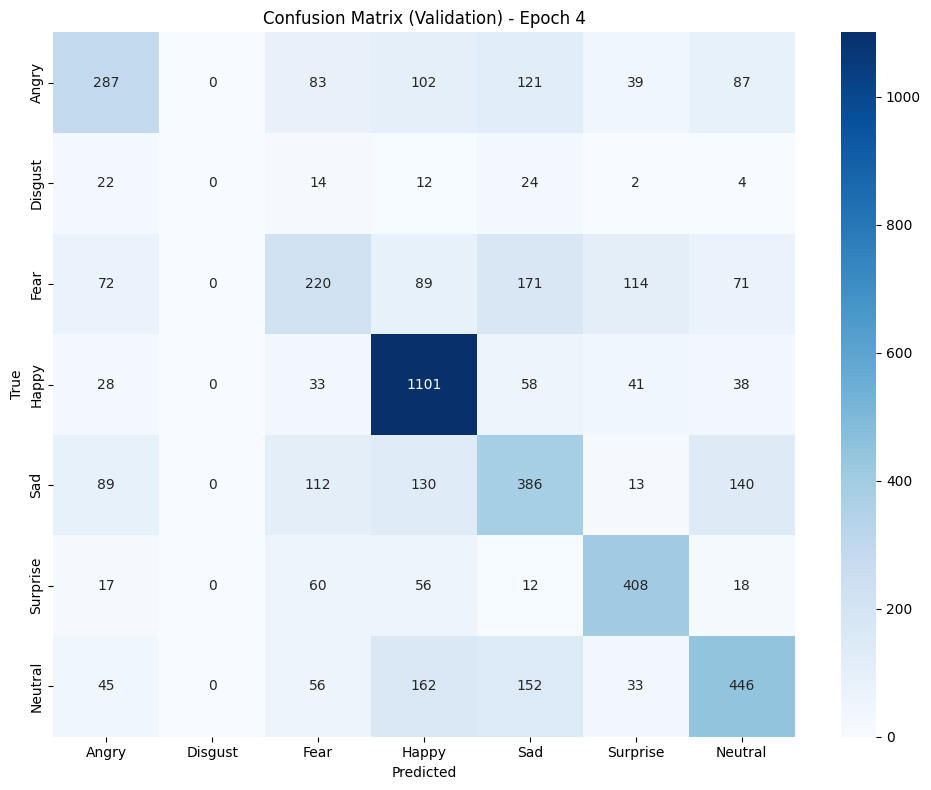

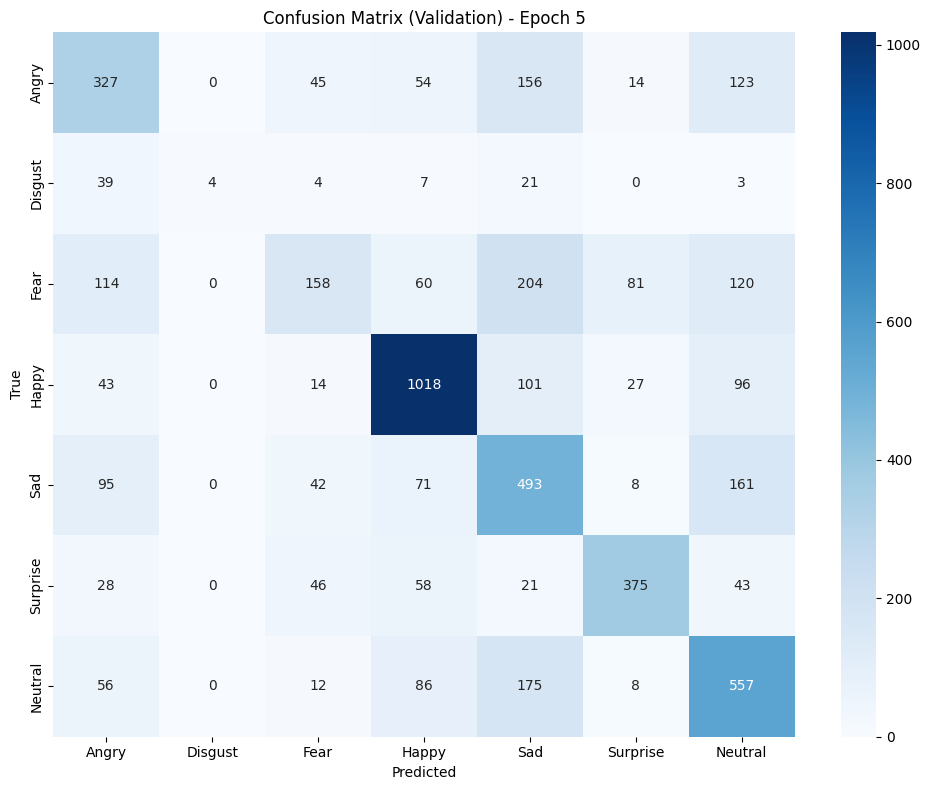

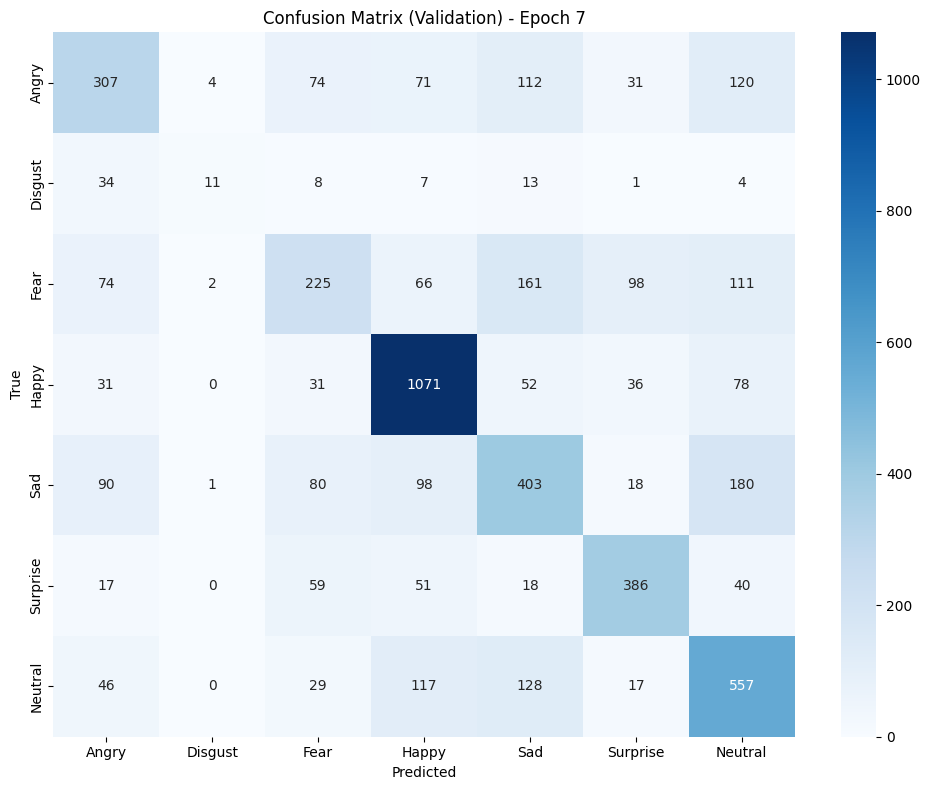

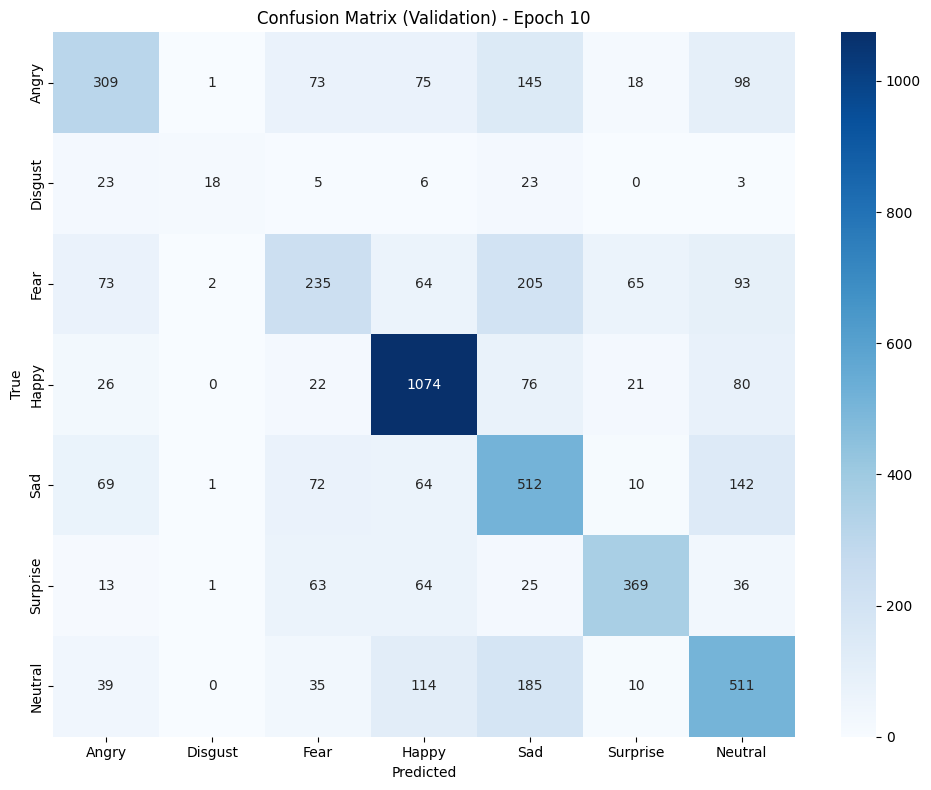

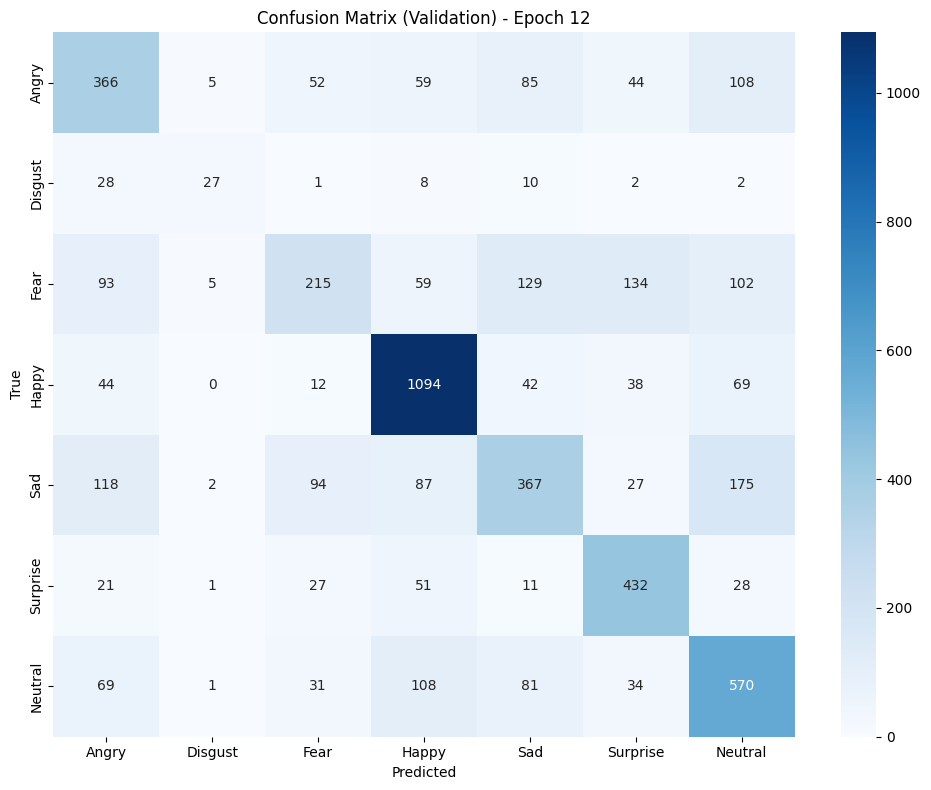

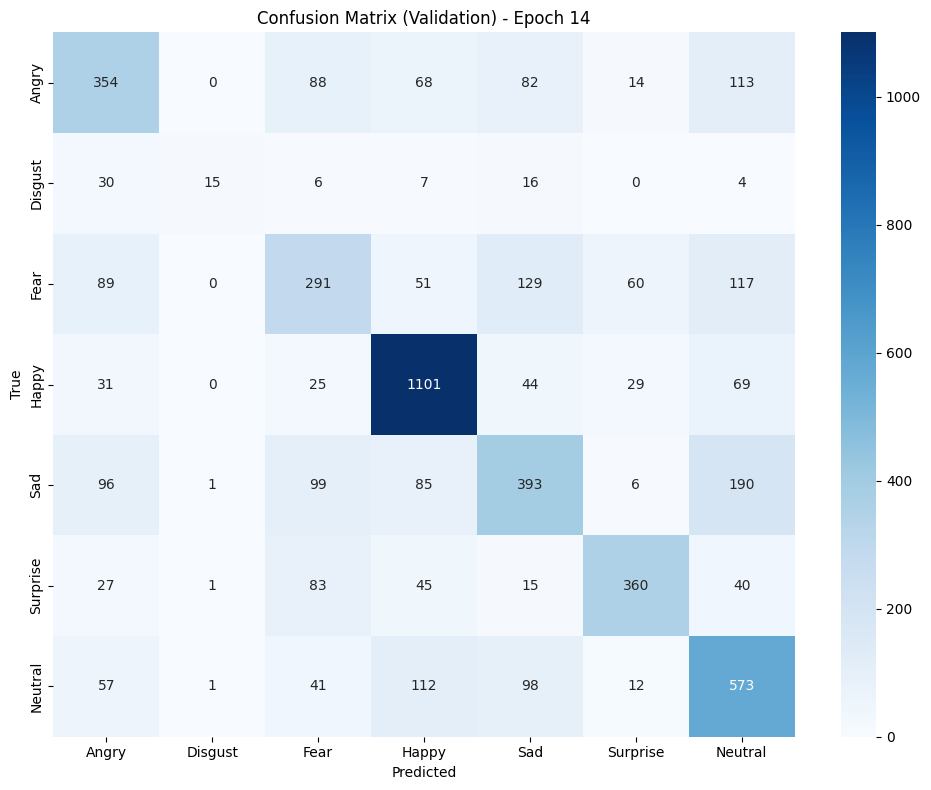

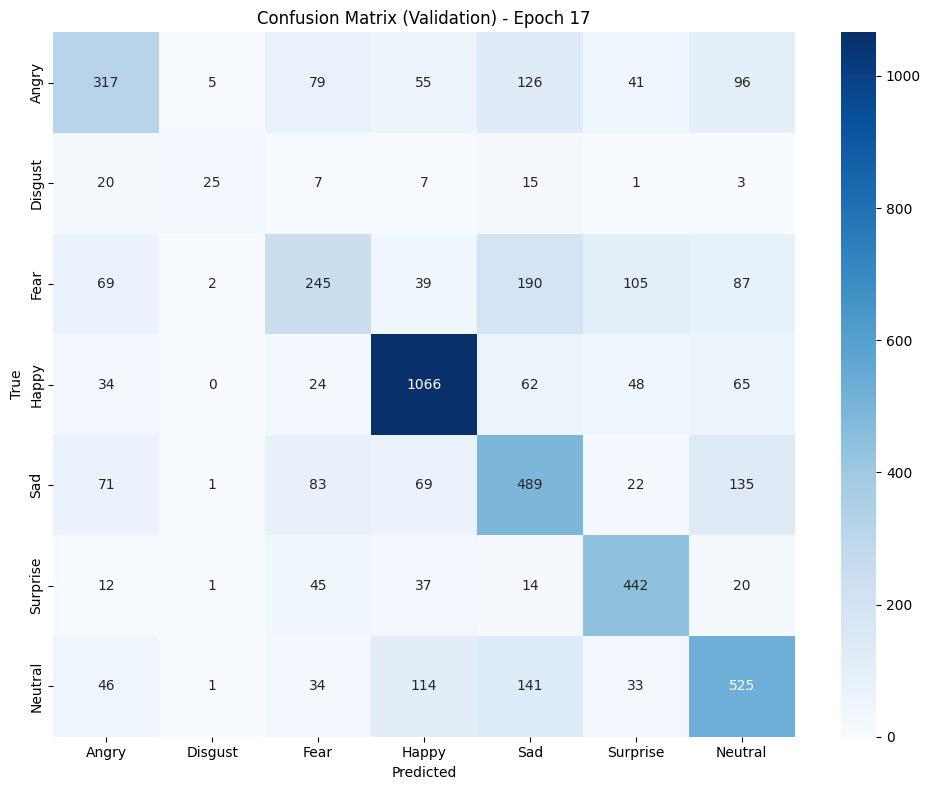

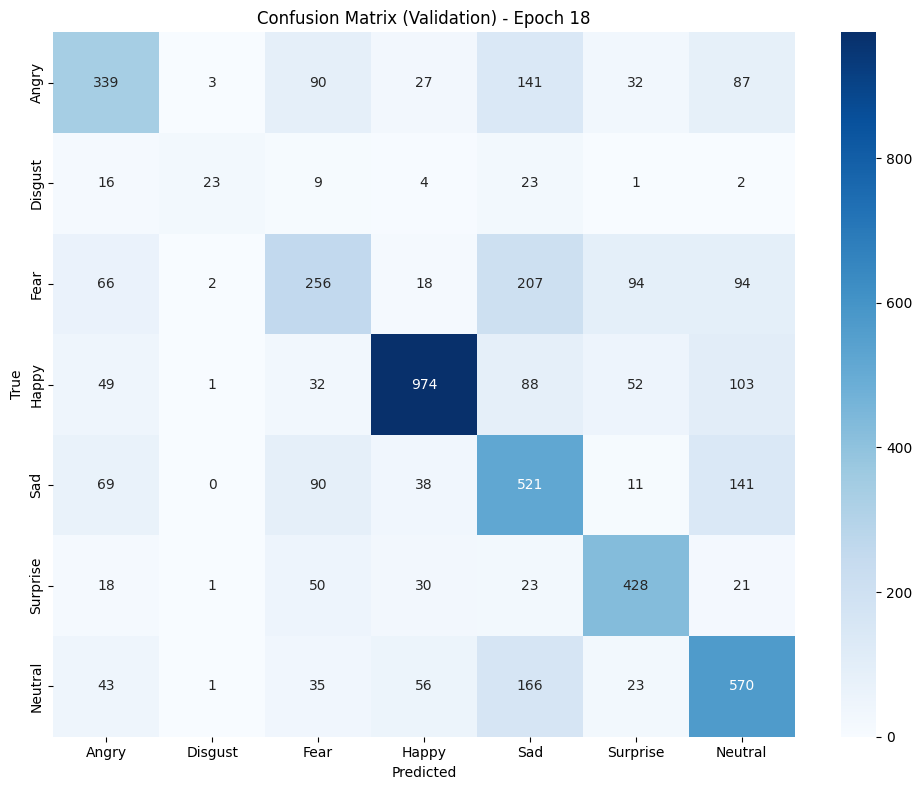

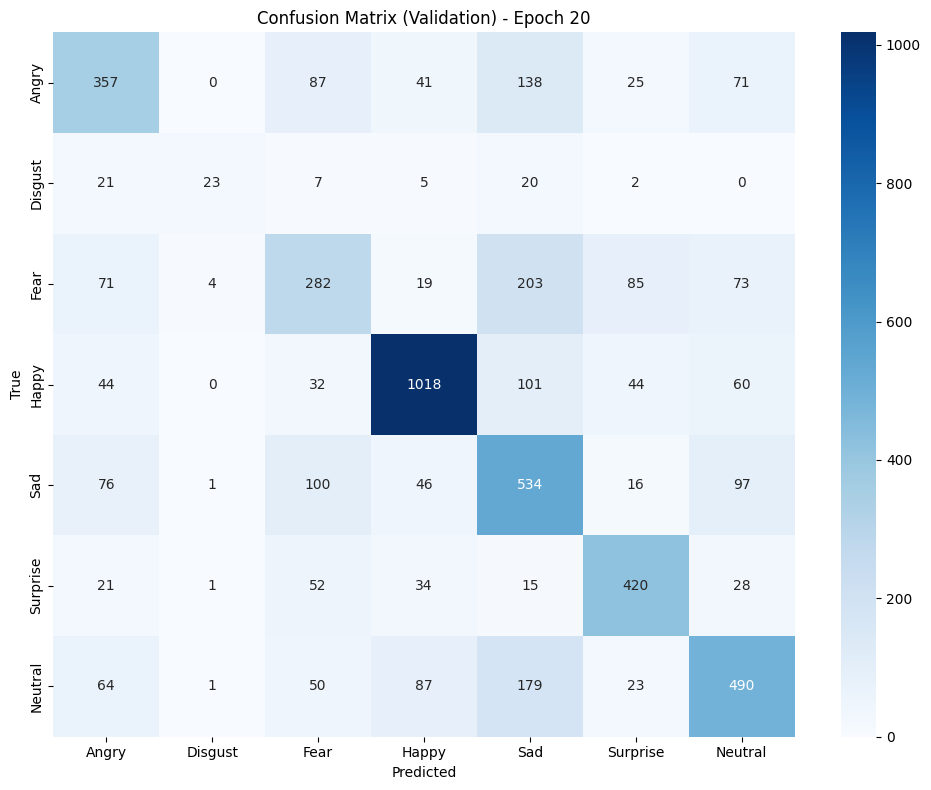

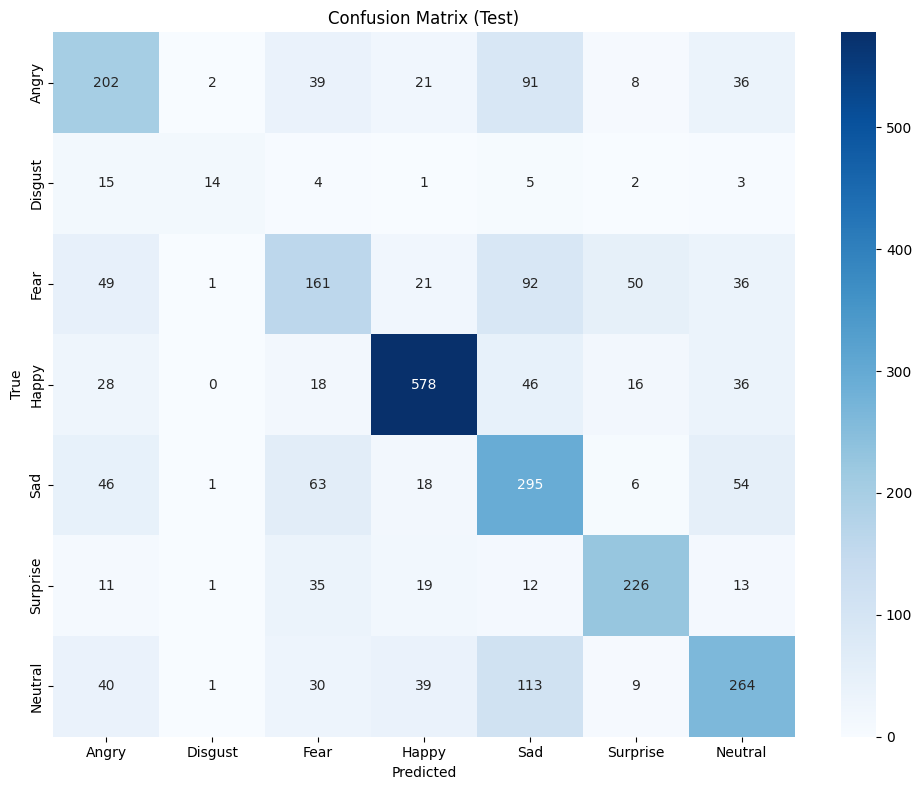

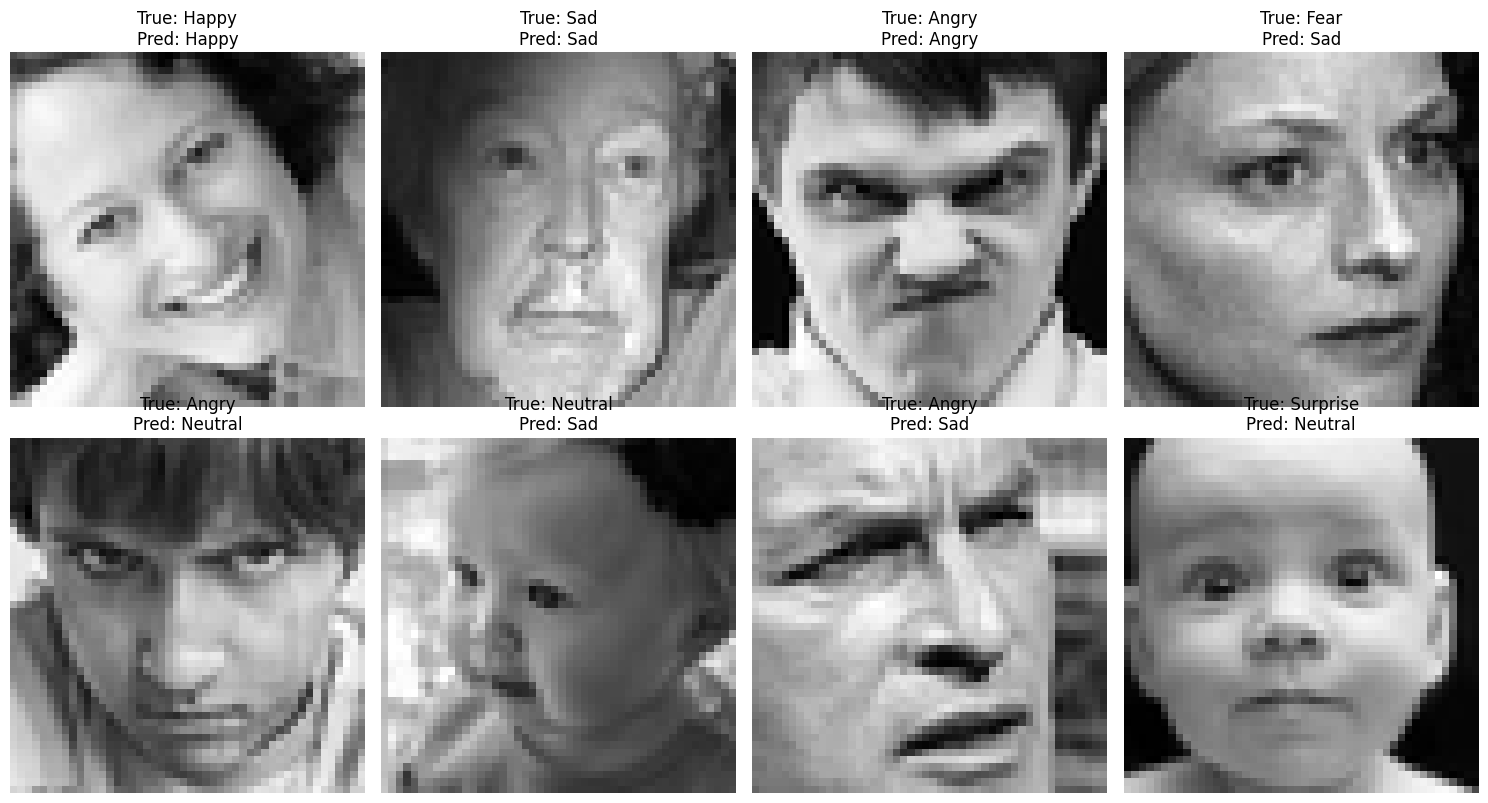

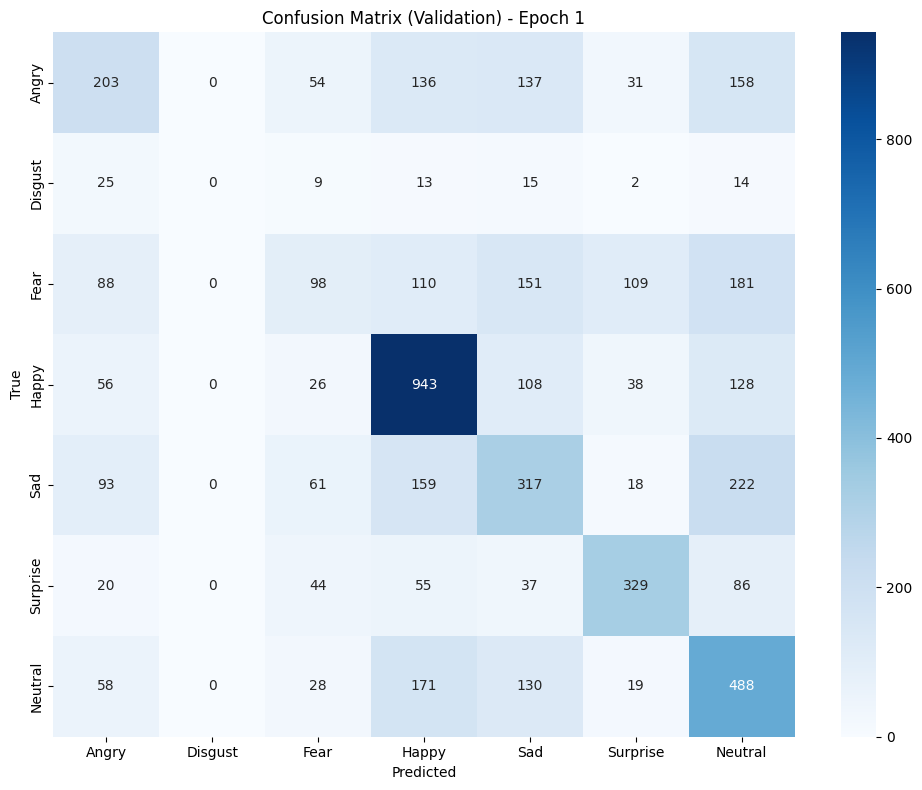

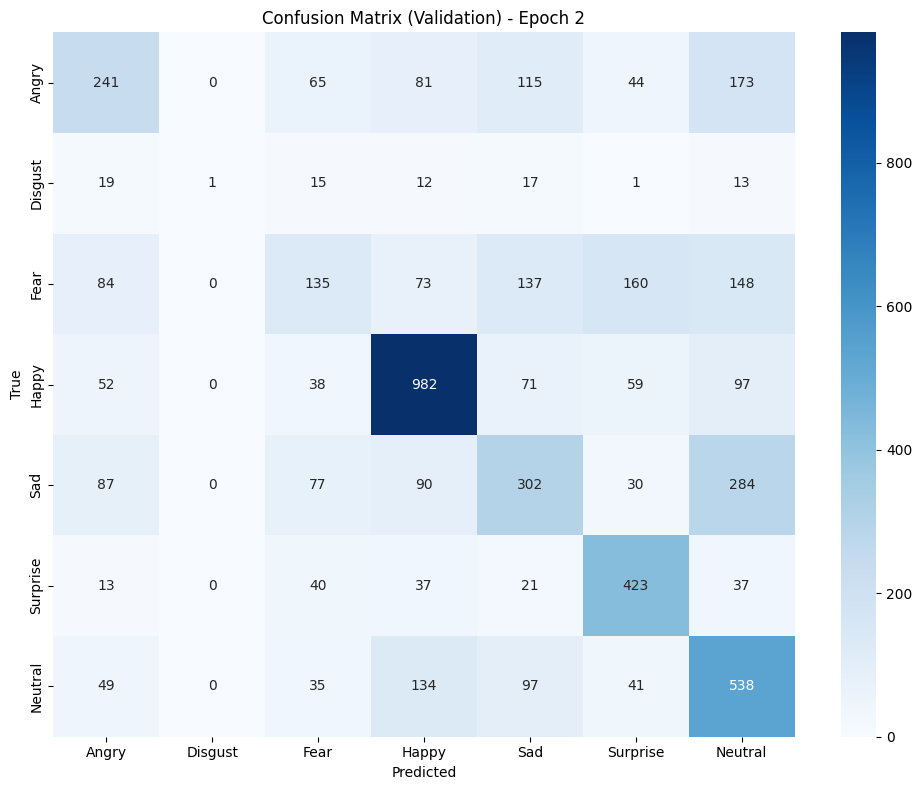

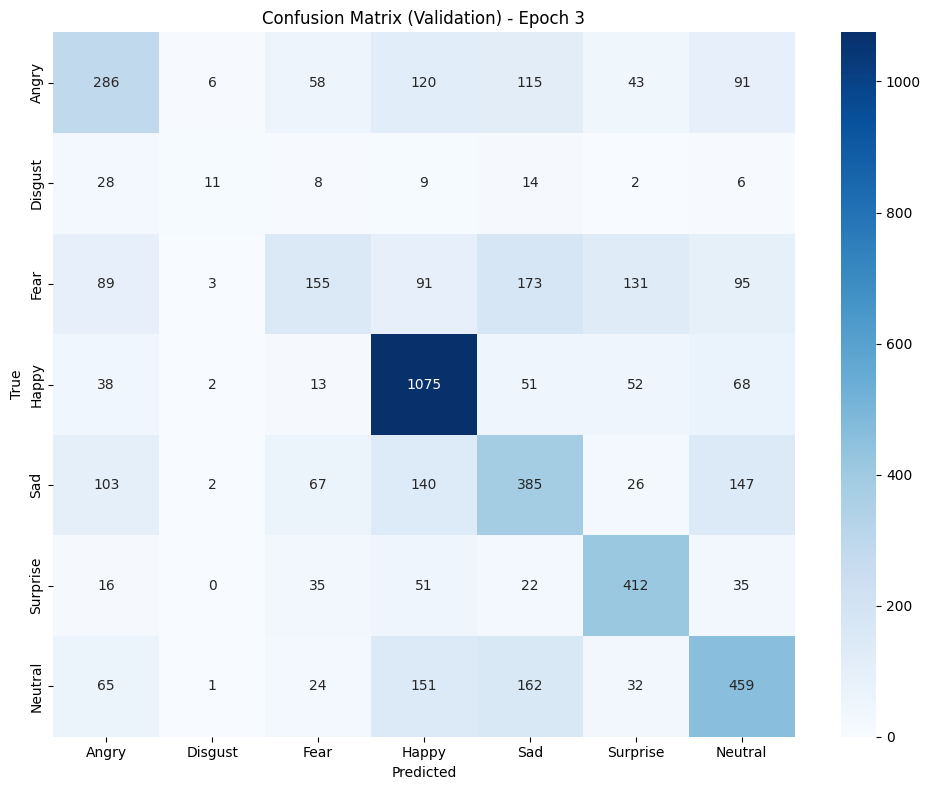

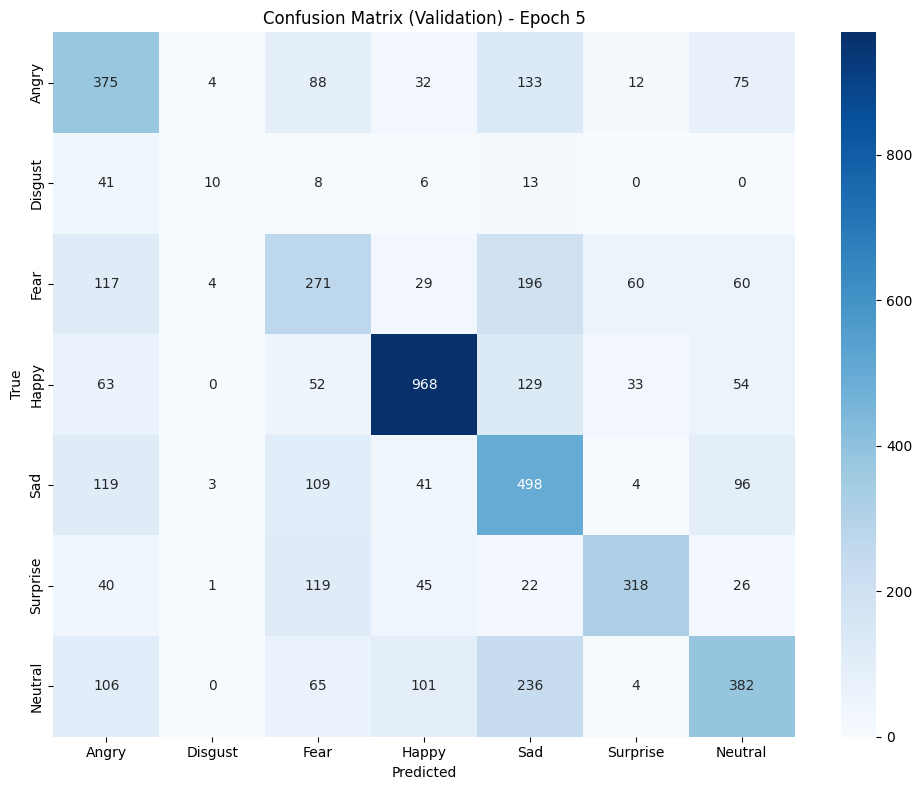

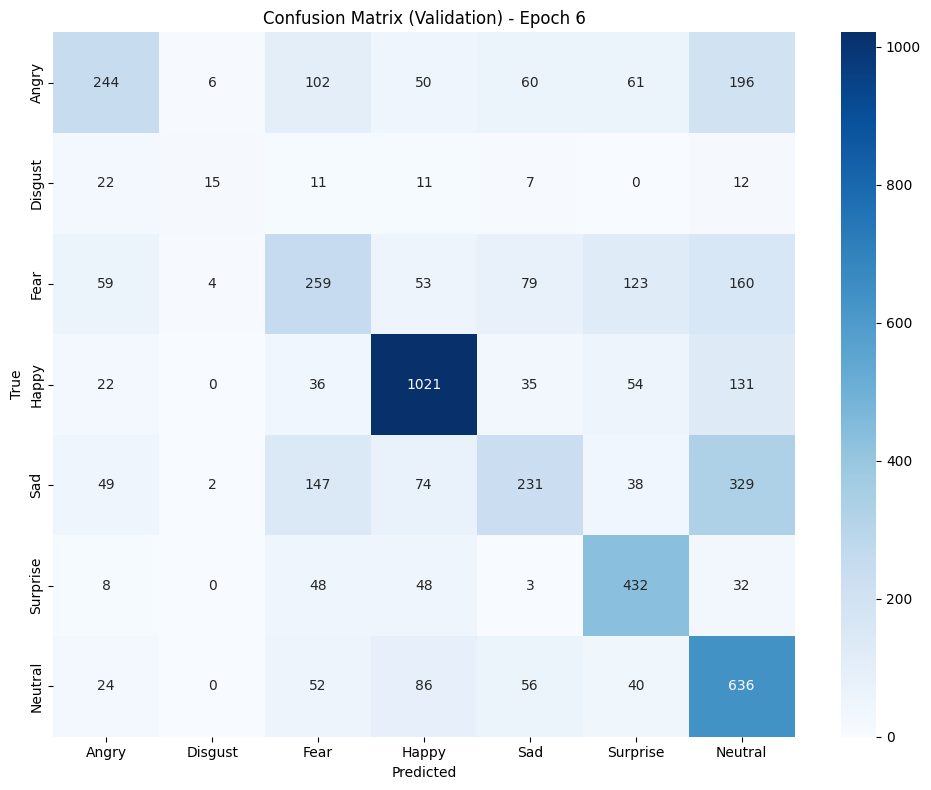

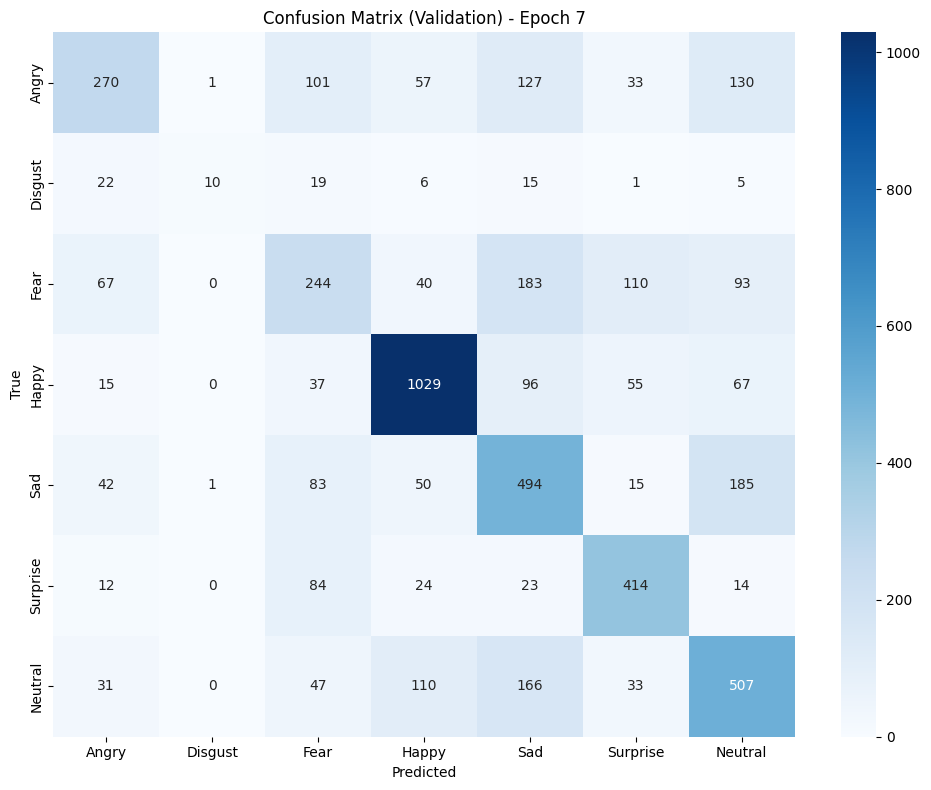

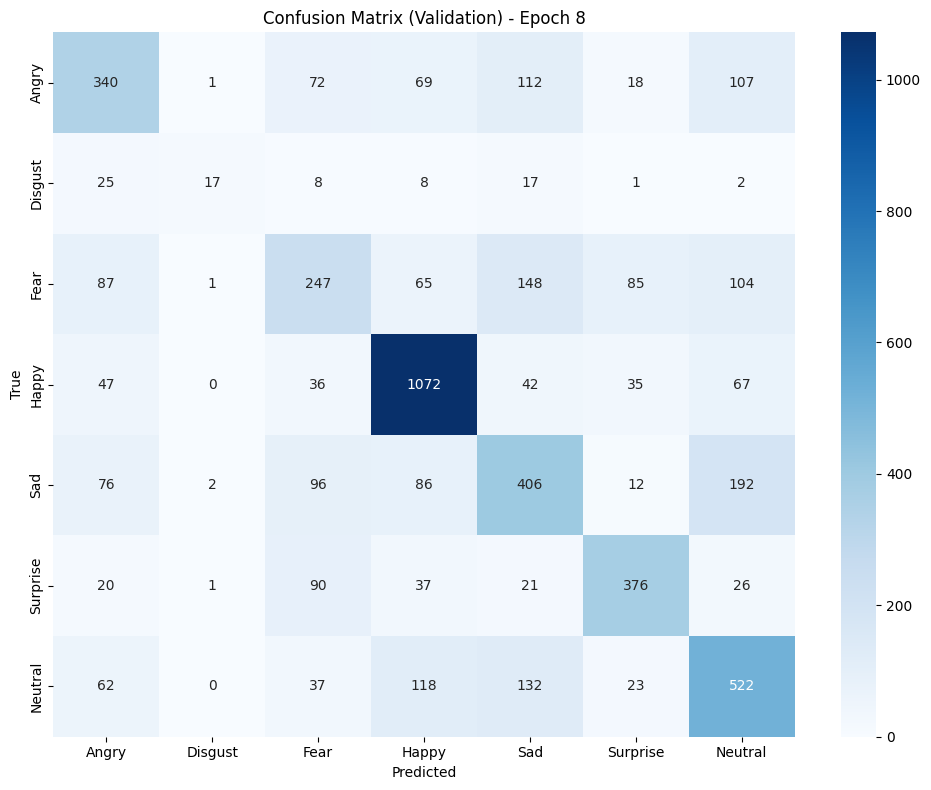

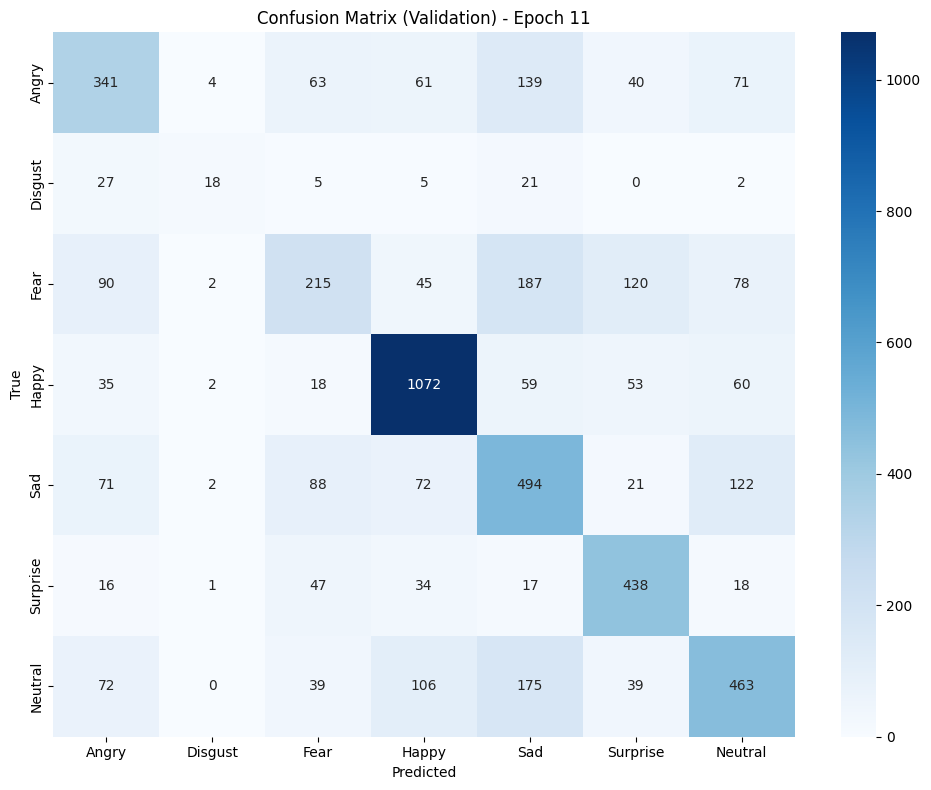

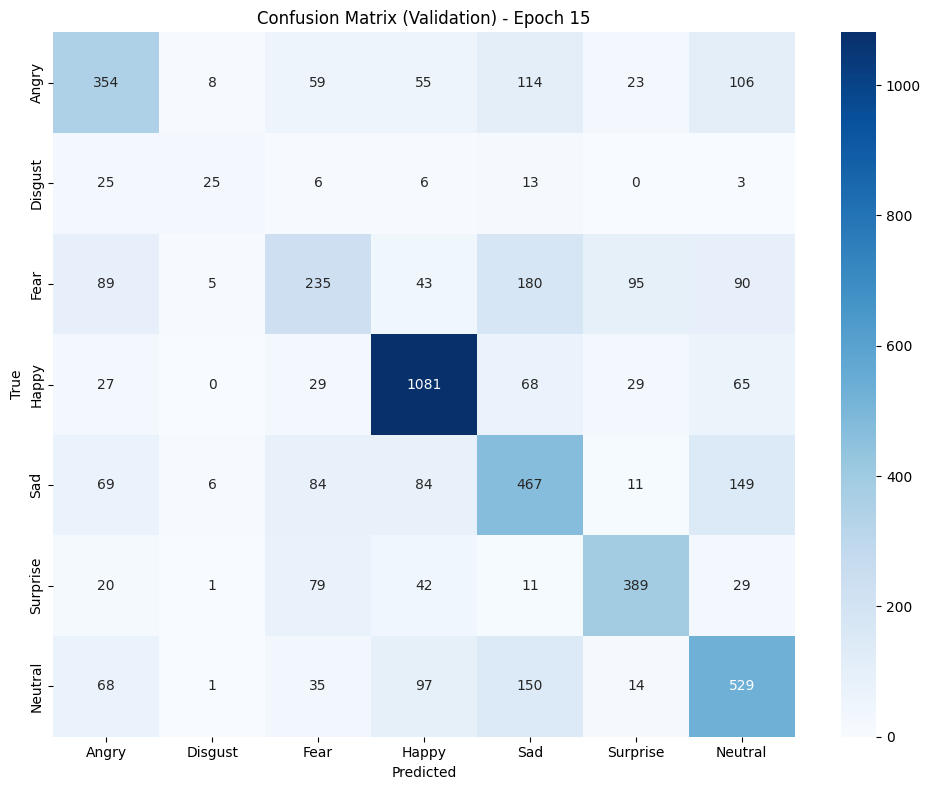

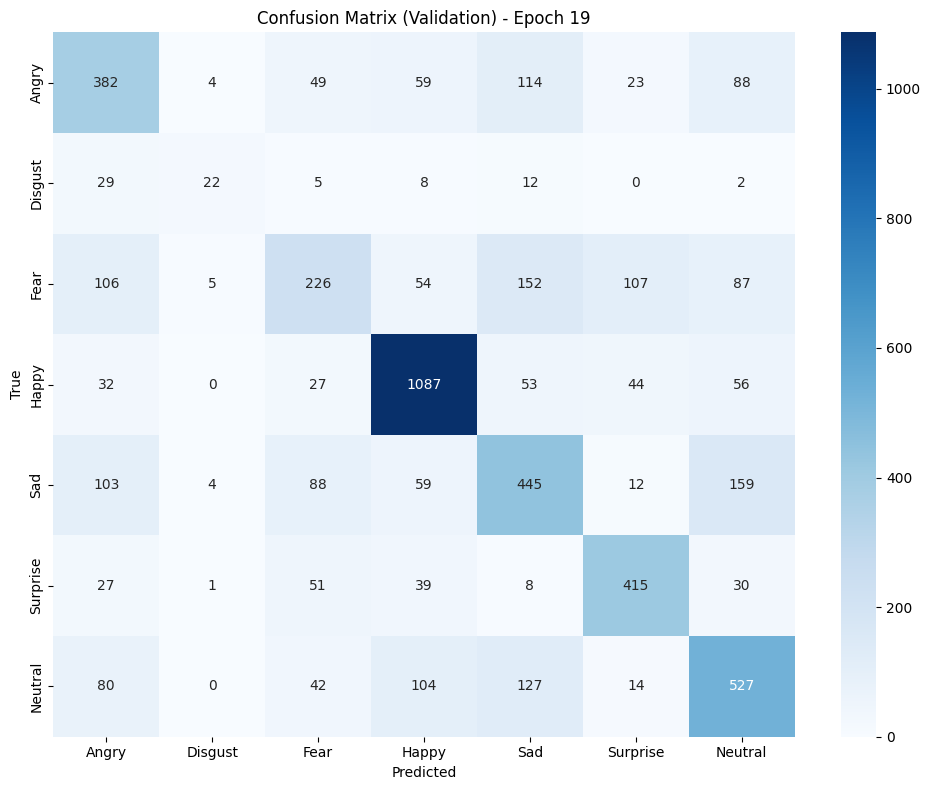

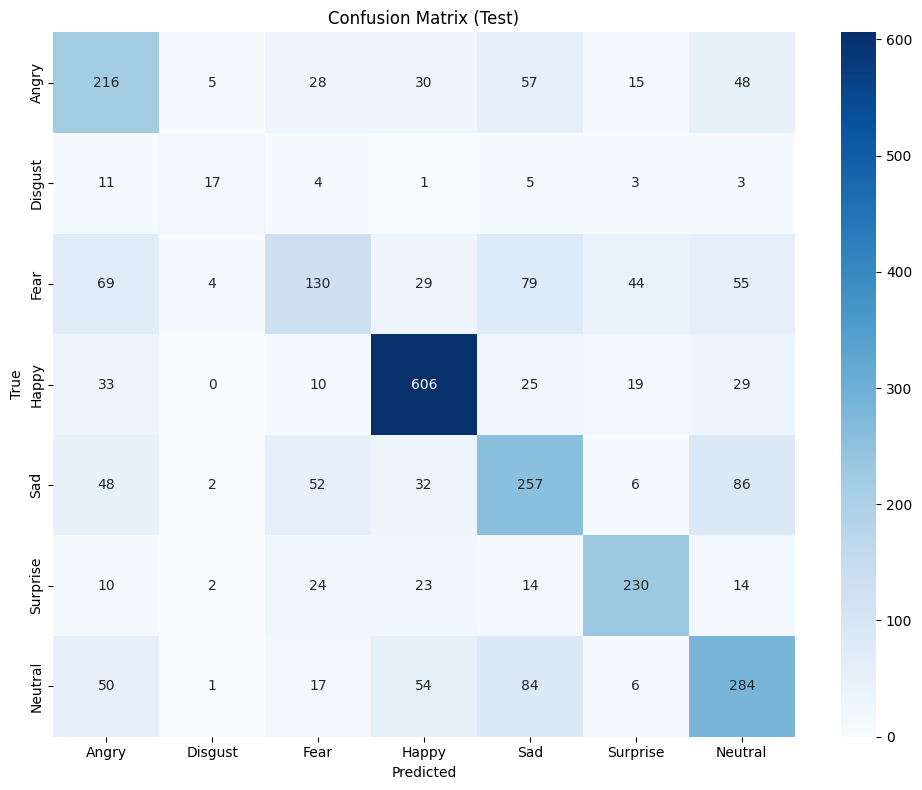

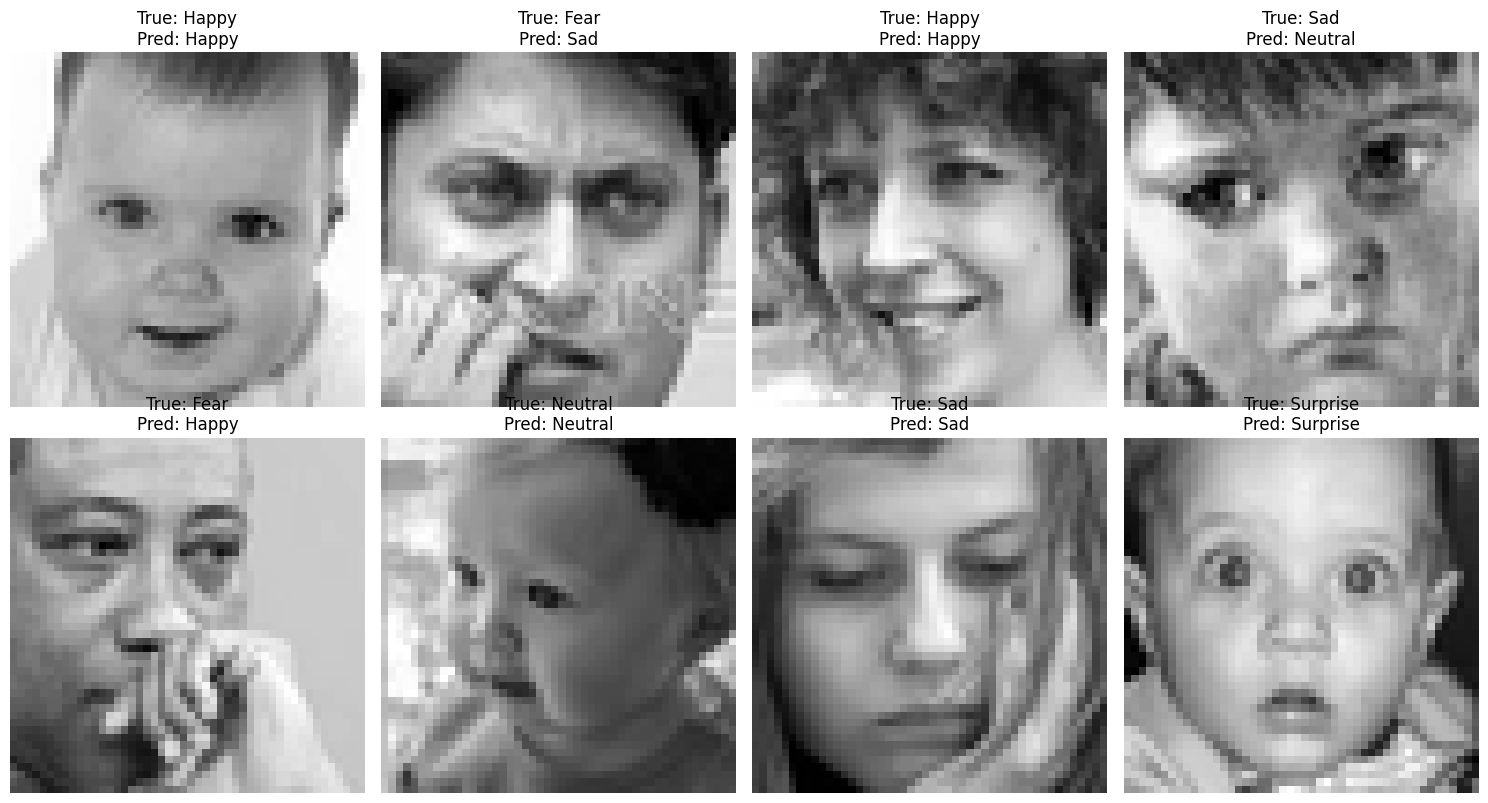

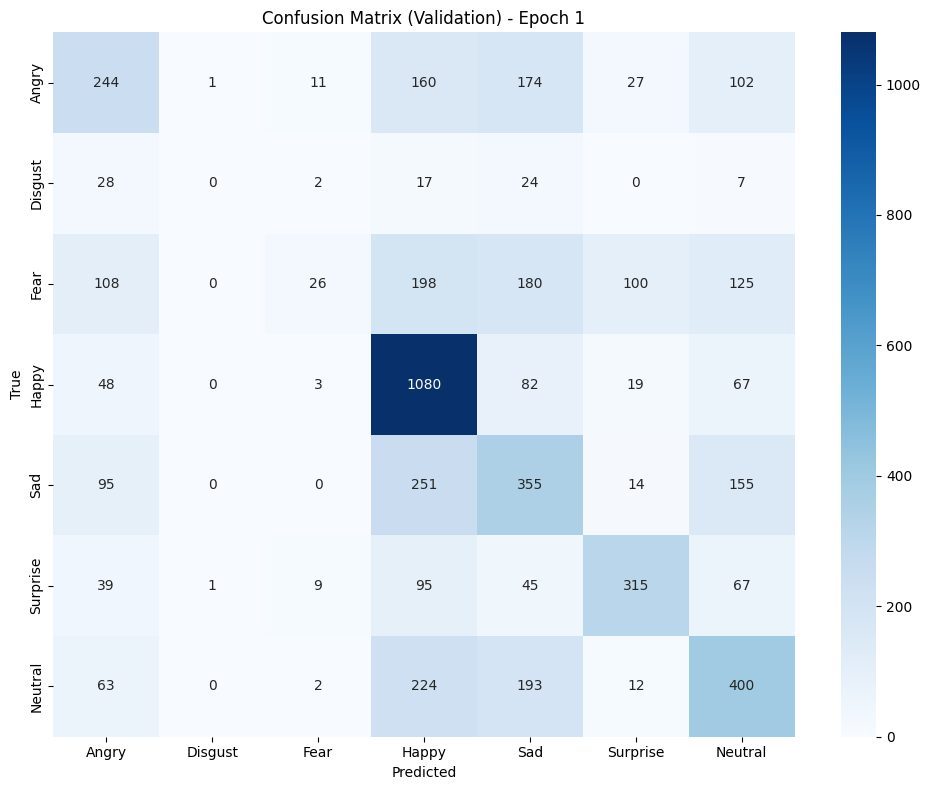

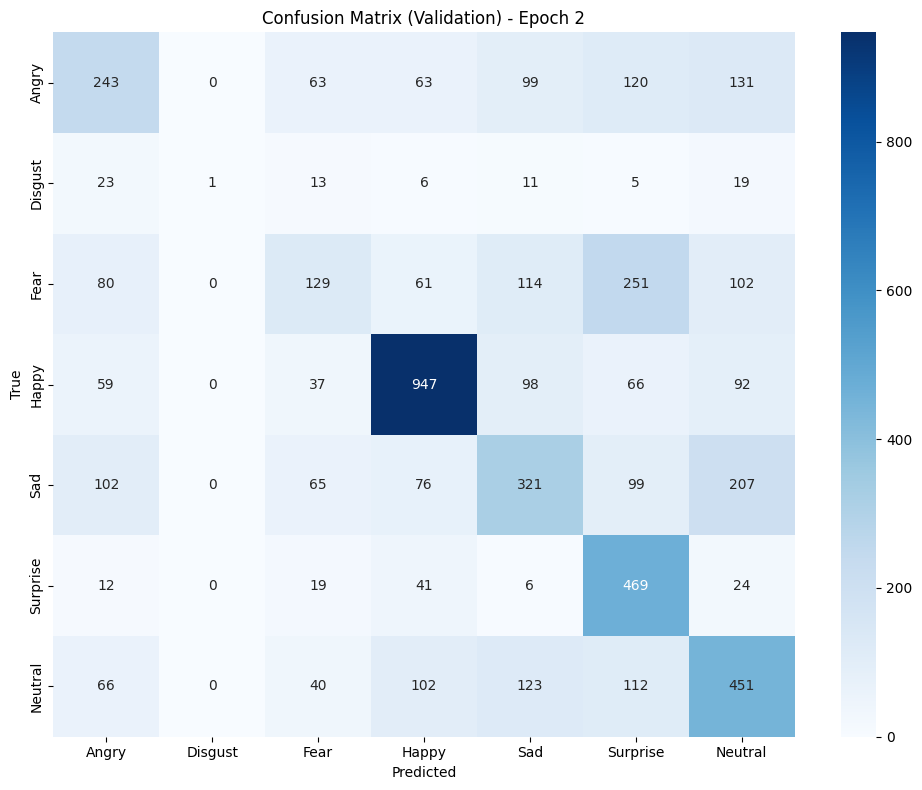

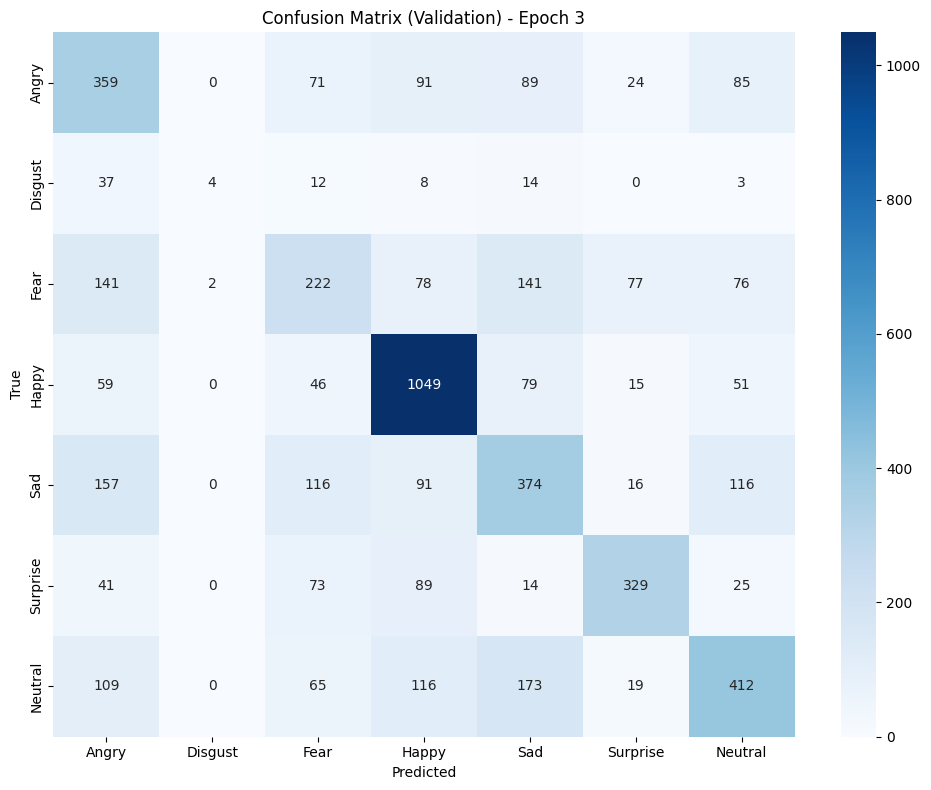

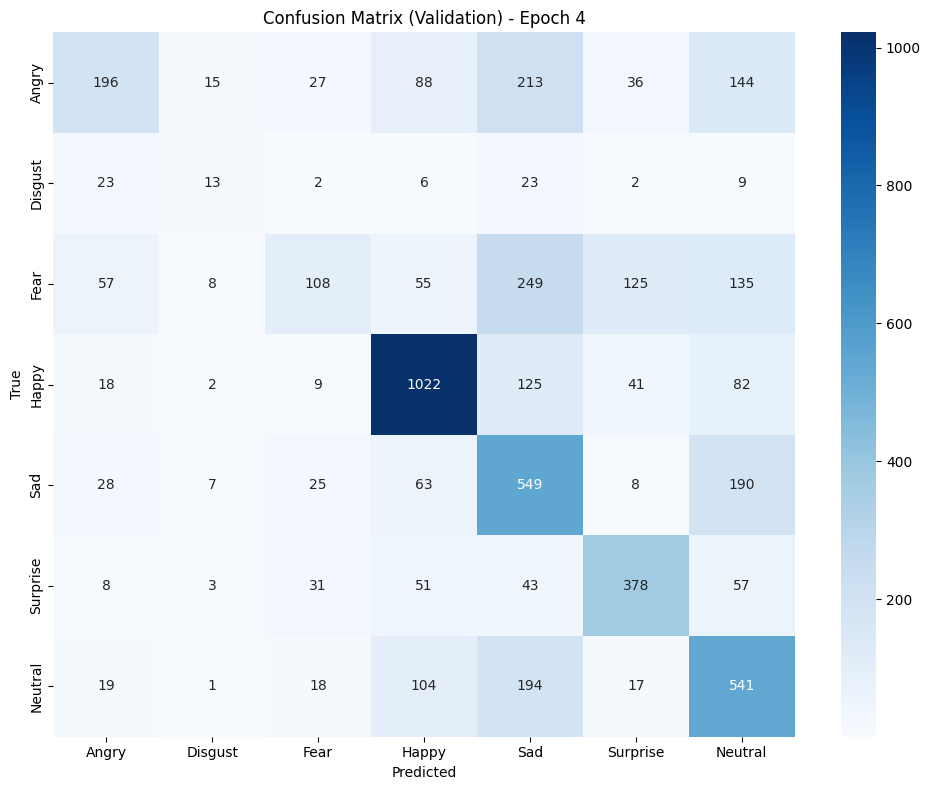

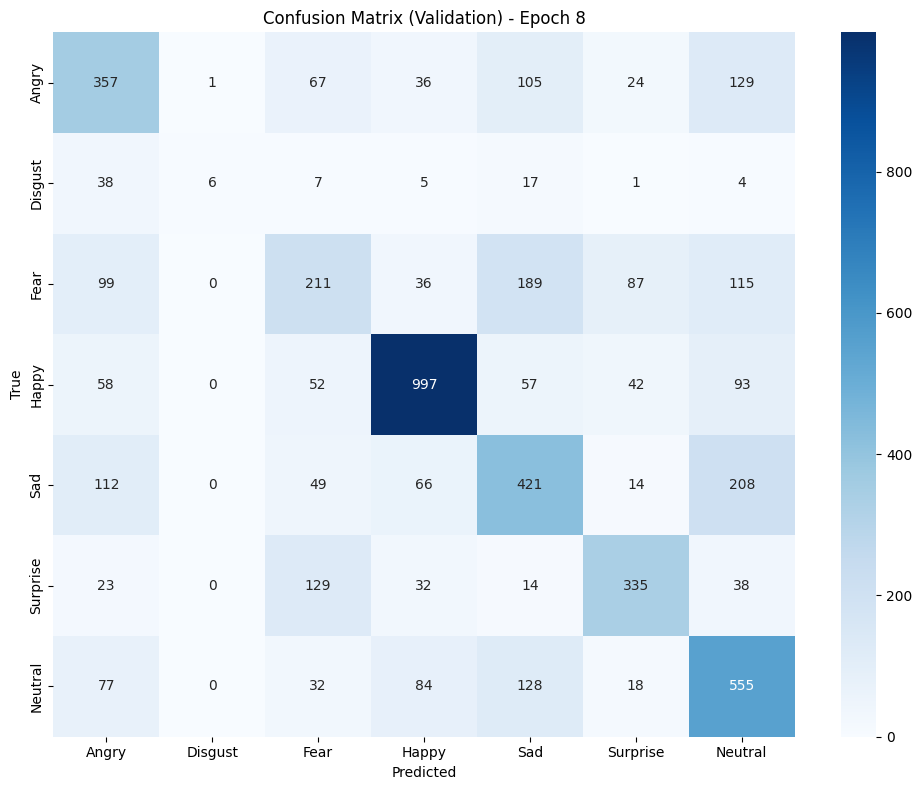

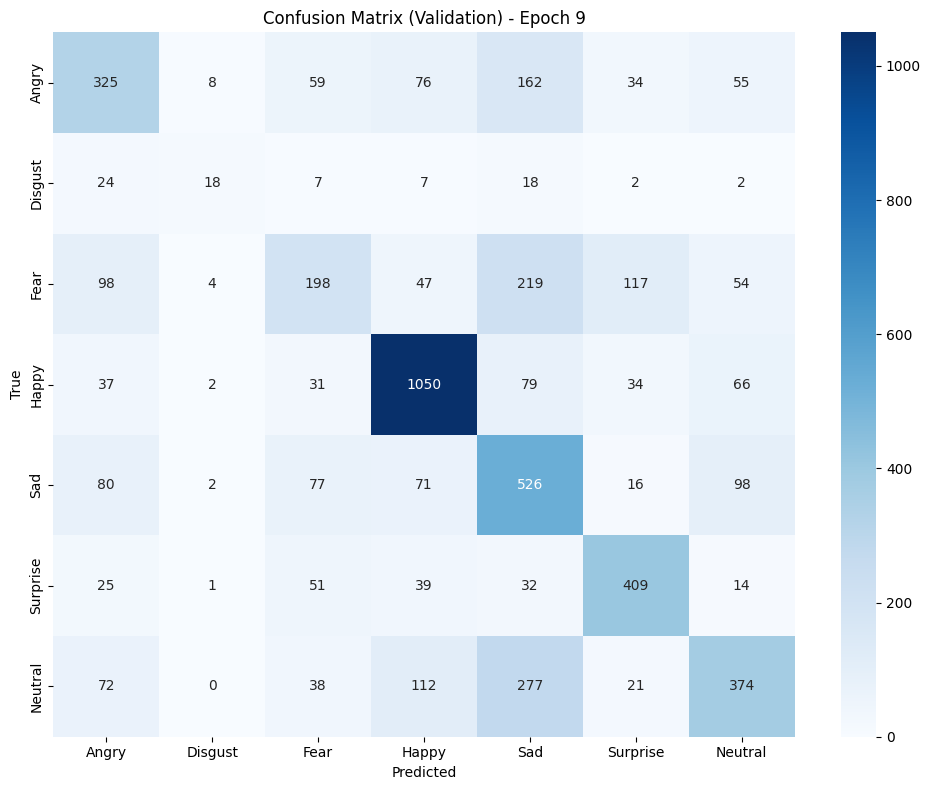

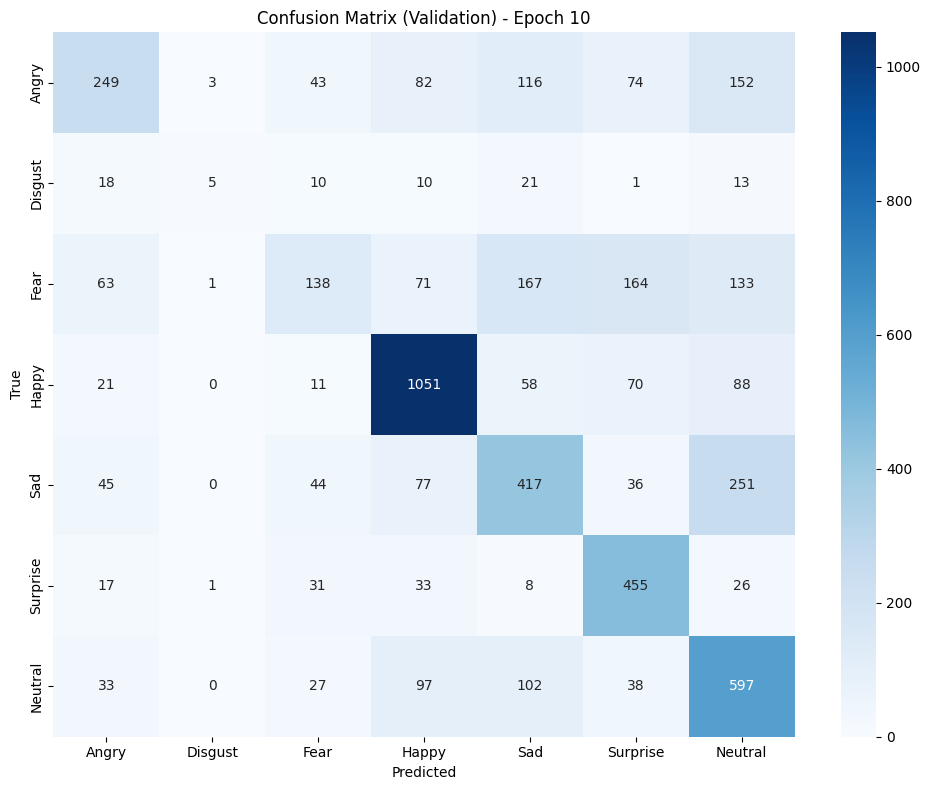

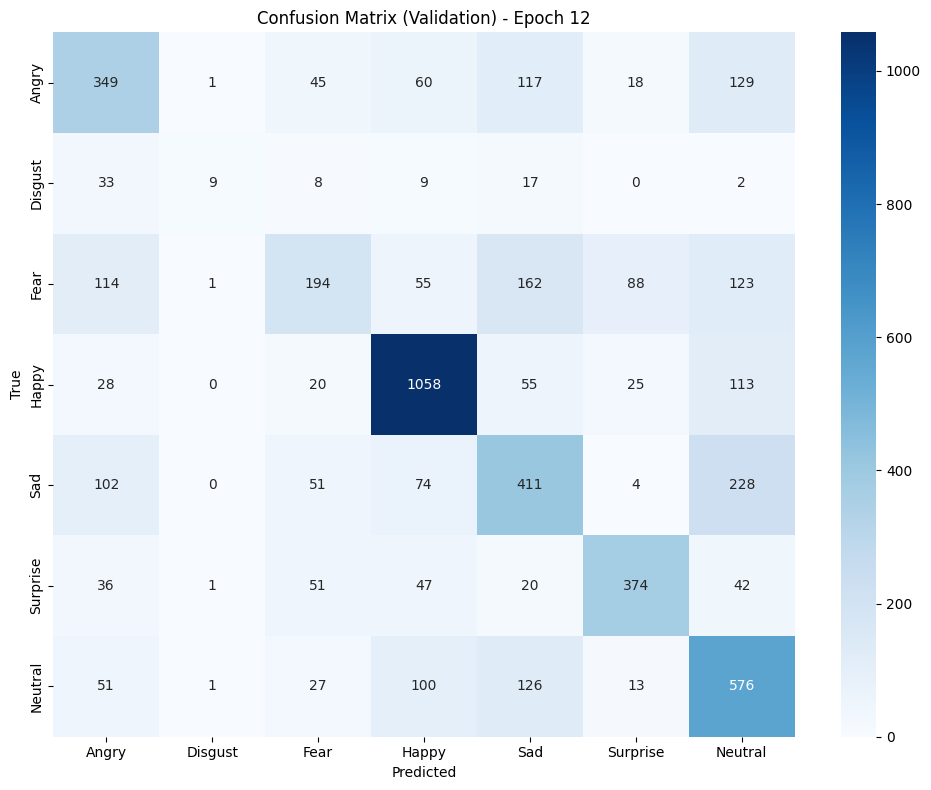

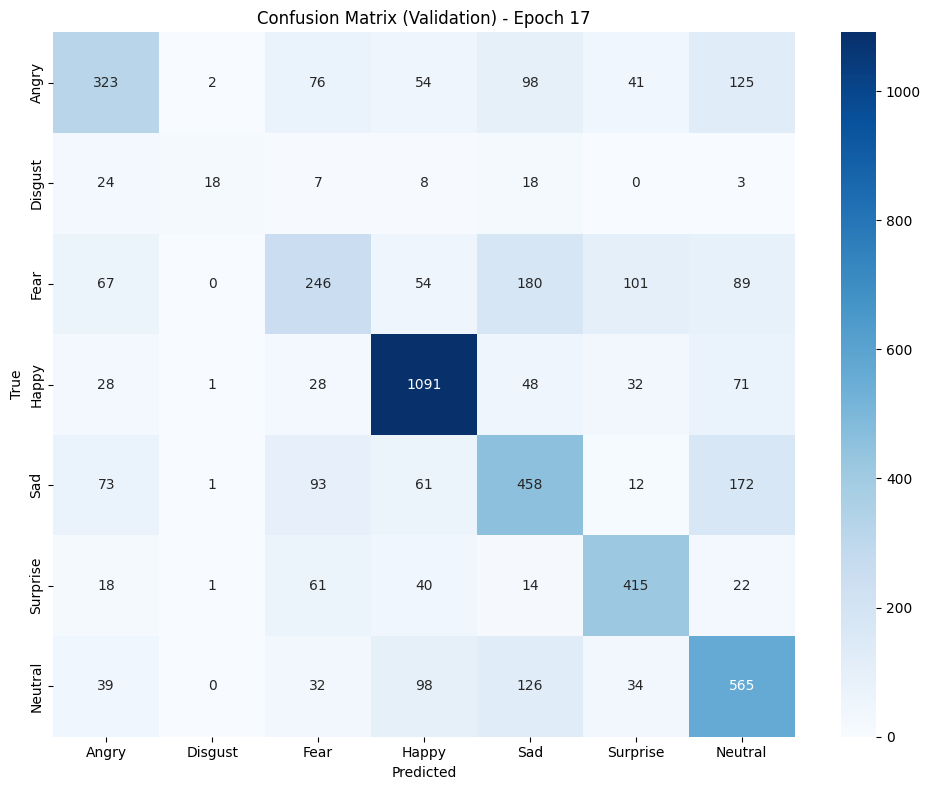

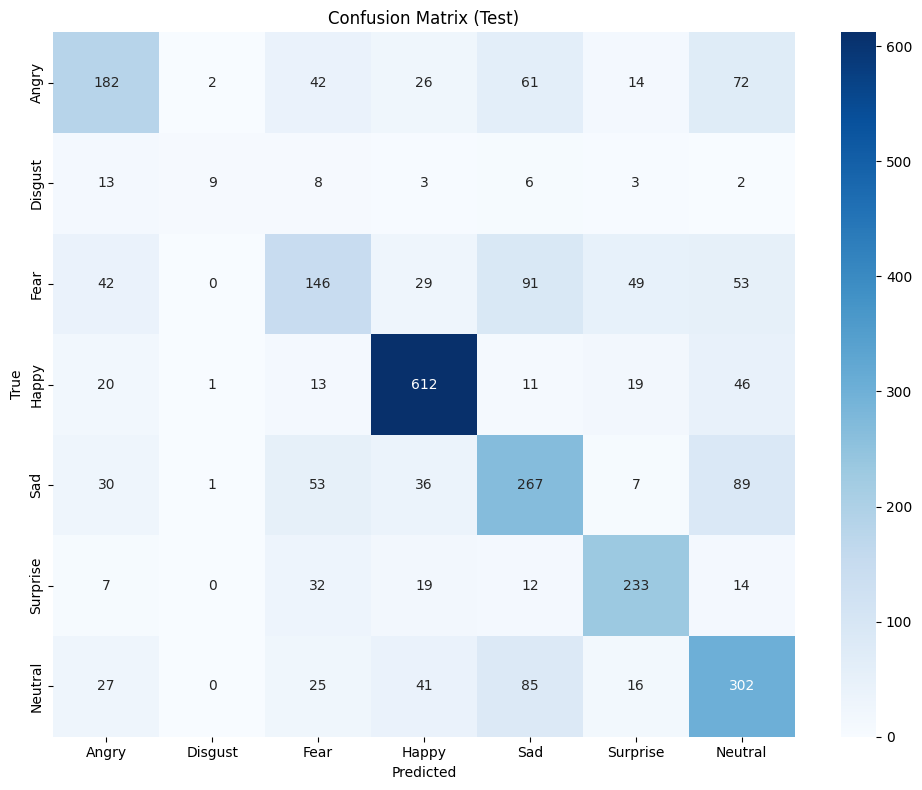

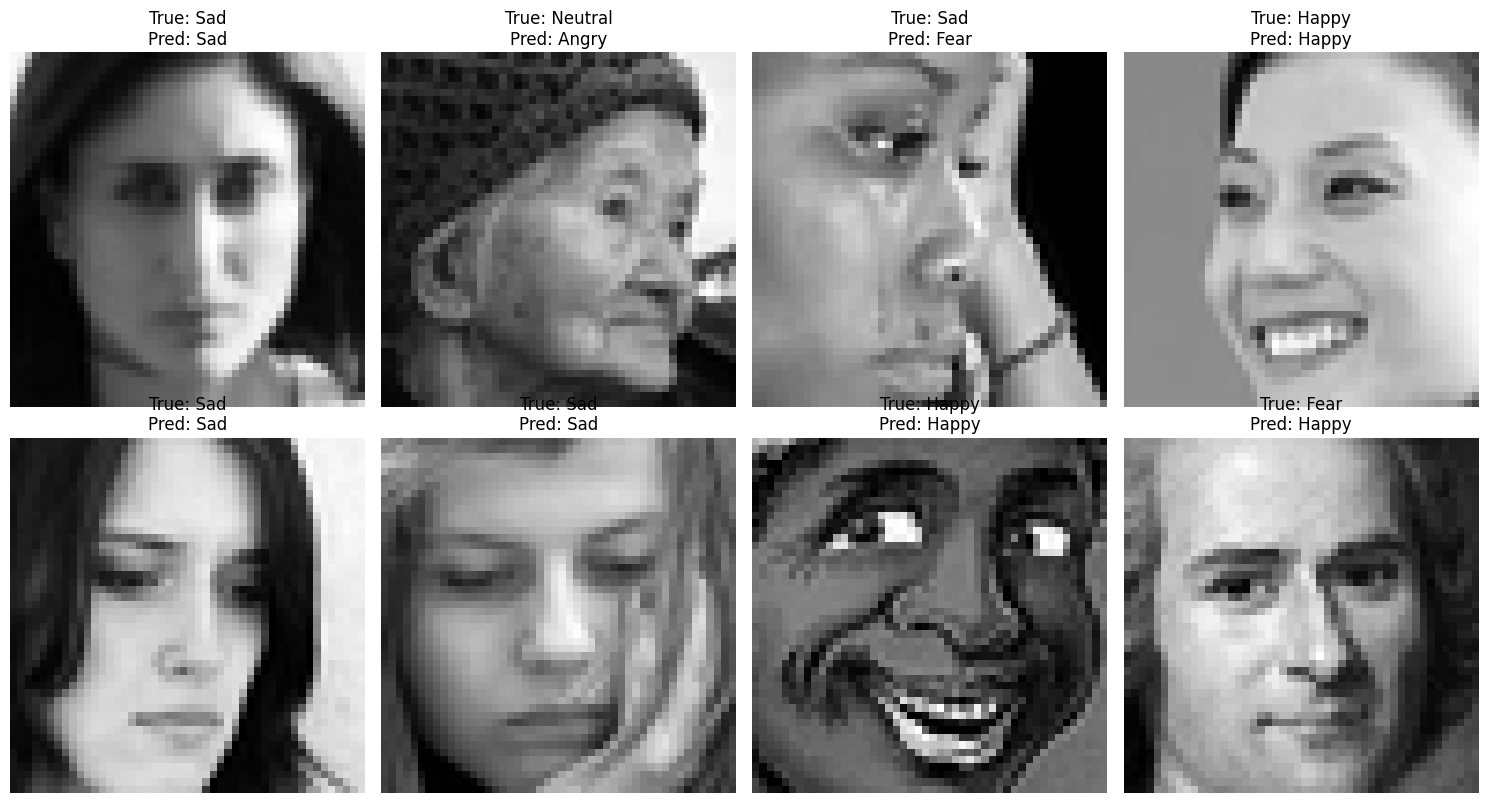

In [31]:
print("\nRunning hyperparameter sweep to find the best model...")
wandb.agent(sweep_id, train_model, count=3)



Best run found: scarlet-sweep-1
Best validation accuracy: 60.45%
Hyperparameters: {'batch_size': 128, 'hidden_dim': 64, 'dropout_rate': 0.2, 'weight_decay': 1e-06, 'learning_rate': 0.001}

Final Test Accuracy with best model: 60.61%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.52      0.51      0.51       399
     Disgust       0.70      0.32      0.44        44
        Fear       0.46      0.39      0.42       410
       Happy       0.83      0.80      0.81       722
         Sad       0.45      0.61      0.52       483
    Surprise       0.71      0.71      0.71       317
     Neutral       0.60      0.53      0.56       496

    accuracy                           0.61      2871
   macro avg       0.61      0.55      0.57      2871
weighted avg       0.61      0.61      0.61      2871

Error loading or evaluating best model: You must call wandb.init() before wandb.log()
You may need to manually download the best model from W&B.


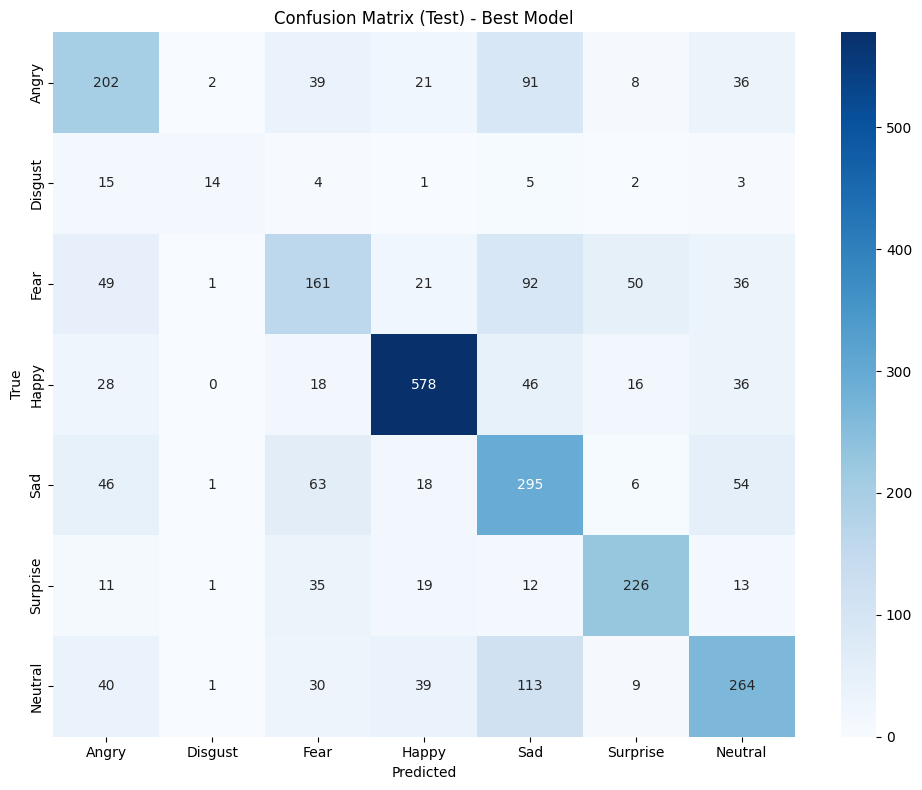

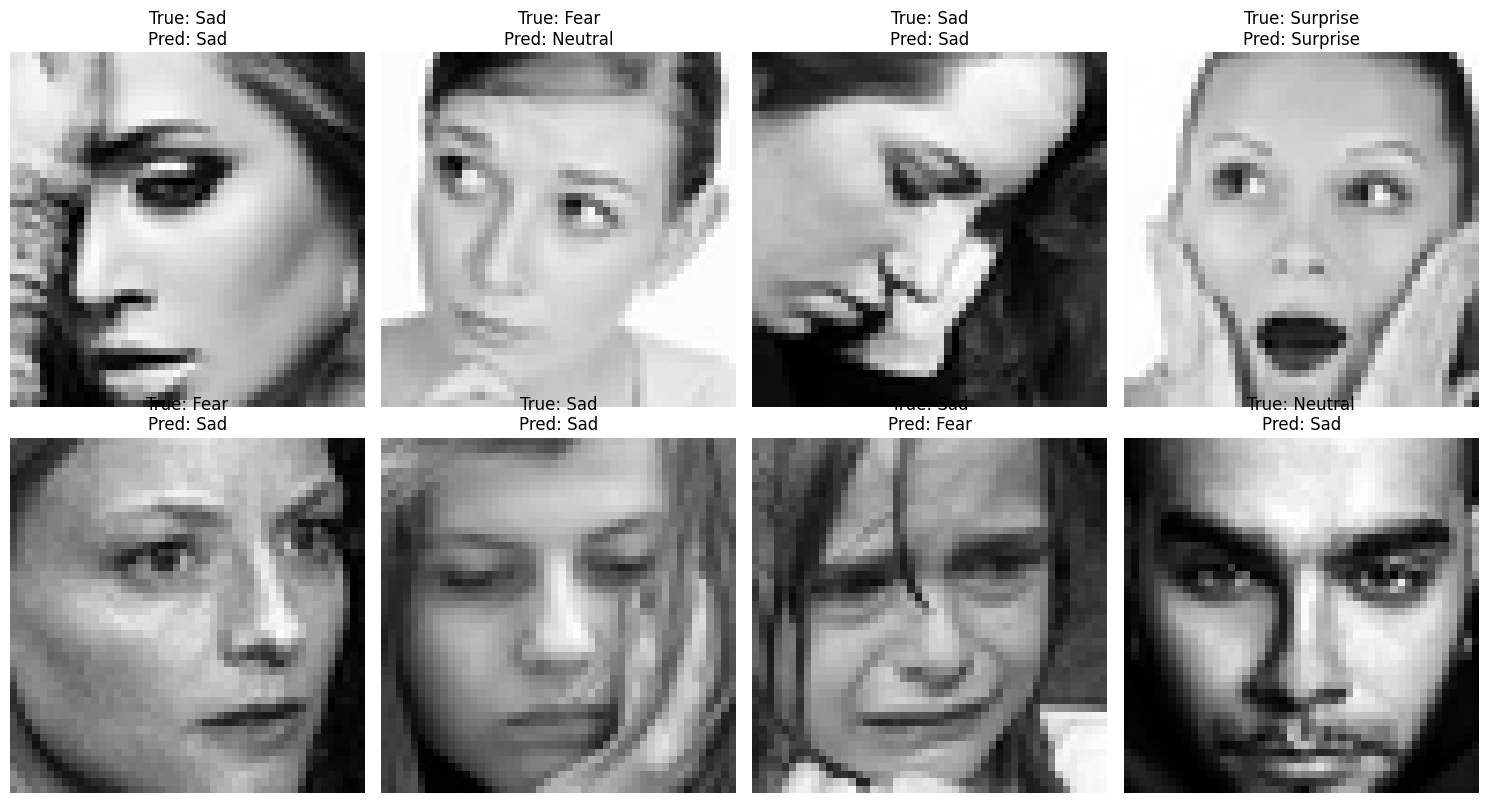

In [32]:
api = wandb.Api()
sweep = api.sweep(f"konstantine25b-free-university-of-tbilisi-/Facial_Expression_Recognition_3/sweeps/{sweep_id}")
runs = sorted(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0), reverse=True)
if runs:
    best_run = runs[0]
    print(f"\nBest run found: {best_run.name}")
    print(f"Best validation accuracy: {best_run.summary.get('val_accuracy', 0):.2f}%")
    print(f"Hyperparameters: {best_run.config}")

    # Load the best model for evaluation
    best_model_path = f"best_model_{best_run.id}.pt"

    try:
        # Create model with the best hyperparameters
        best_model = ImprovedCNN(
            dropout_rate=best_run.config.get('dropout_rate', 0.3),
            hidden_dim=best_run.config.get('hidden_dim', 128)
        ).to(device)

        # Load the model weights
        best_model.load_state_dict(torch.load(best_model_path))

        # Create dataloaders with the best batch size
        _, _, test_loader, _ = create_dataloaders(best_run.config.get('batch_size', 64))

        # Test the model
        test_accuracy, test_preds, test_labels = compute_accuracy(test_loader, best_model, device)

        # Compute per-class metrics
        report = classification_report(test_labels, test_preds,
                                      target_names=list(emotion_labels.values()),
                                      output_dict=True)

        print(f"\nFinal Test Accuracy with best model: {test_accuracy:.2f}%")
        print("\nClassification Report:")
        print(classification_report(test_labels, test_preds, target_names=list(emotion_labels.values())))

        # Create confusion matrix for test set
        cm = confusion_matrix(test_labels, test_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(emotion_labels.values()),
                    yticklabels=list(emotion_labels.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Test) - Best Model')
        plt.tight_layout()
        plt.savefig('best_model_confusion_matrix.png')

        # Visualize some predictions with the best model
        visualize_predictions(test_loader, best_model, emotion_labels, device)

    except Exception as e:
        print(f"Error loading or evaluating best model: {e}")
        print("You may need to manually download the best model from W&B.")
else:
    print("No completed runs found in the sweep.")

In [33]:
wandb.finish()